<a href="https://colab.research.google.com/github/S21810014/dsp-covid19-visualization-and-forecast/blob/main/Visualisasi_dan_Forecasting_data_Covid_19_Timothy_Merfry_Tiwow_DSP_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Versi November 19, 2021
Ini adalah Colaboratory Notebook untuk memenuhi tugas 'Forecasting' di kelas Data Science Programming A

Dibuat oleh Timothy Merfry Tiwow (S21810014/105021810004) dengan bantuan material yang telah diberikan melalui Google Classroom dan googling di internet

***PROGRESS:***

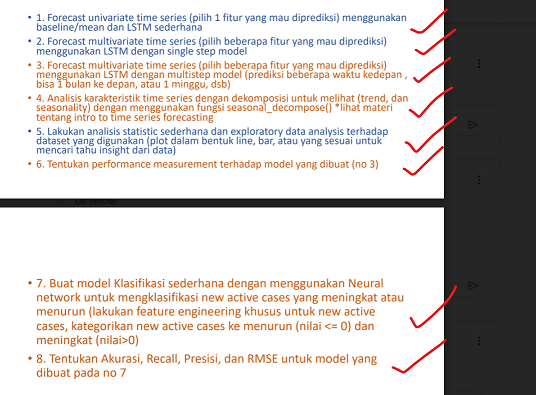

# Persiapan Data

Sebelum memulai visualisasi dan forecasting, data dimuat ke dalam lingkungan Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls drive/MyDrive/dsp

 archive.zip					 gadm36_IDN_3.shx
 combined_timesteps_excel.csv			 normalizedCombTimes.csv
 covid_19_indonesia_time_series_sampai_nov.csv	 Peta.png
 gadm36_IDN_3.dbf				 tb_clean_preprocessed.csv
 gadm36_IDN_3.shp				'Untitled Diagram.drawio'


In [ ]:
#khusus for ini notebook, mesti pake matplotlib versi 3.4.3 ato yang lebih baru
!pip install --upgrade matplotlib

!pip install --upgrade geopandas

In [ ]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import geopandas as gpd
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.preprocessing import StandardScaler
mpl.rcParams['figure.figsize'] = (8, 6)

In [ ]:
df = pd.read_csv('drive/MyDrive/dsp/covid_19_indonesia_time_series_sampai_nov.csv')

#torang drop kolom-kolom yang statis ato yang nda perlu
df = df.drop(columns=['Location ISO Code', 'Location Level', 'City or Regency', 'Country', 'Continent', 'Time Zone', 'Special Status', 'Total Regencies', 'Total Cities', 'Total Districts', 'Total Urban Villages', 'Total Rural Villages', 'Area (km2)', 'Growth Factor of New Cases', 'Growth Factor of New Deaths',])
df

Date          Location  ...  Case Fatality Rate  Case Recovered Rate
0       3/1/2020       DKI Jakarta  ...              51.28%              100.00%
1       3/2/2020       DKI Jakarta  ...              48.78%               95.12%
2       3/2/2020         Indonesia  ...               0.00%                0.00%
3       3/2/2020              Riau  ...               0.00%                0.00%
4       3/3/2020       DKI Jakarta  ...              46.51%               90.70%
...          ...               ...  ...                 ...                  ...
20811  11/5/2021   Sulawesi Tengah  ...               3.39%               96.28%
20812  11/5/2021    Sulawesi Utara  ...               3.00%               95.74%
20813  11/5/2021    Sumatera Barat  ...               2.39%               97.37%
20814  11/5/2021  Sumatera Selatan  ...               5.12%               94.75%
20815  11/5/2021    Sumatera Utara  ...               2.73%               96.95%

[20816 rows x 23 columns]

Setelah data dimuat, kolom-kolom dari data tersebut masih bertipe Object, maka dari itu perlu dilakukan konversi ke tipe-tipe yang sesuai dari kolom data tersebut

In [ ]:
columnsTypeMap = {
    'Date': "Date",
    'New Cases': "float",
    'New Deaths': "float",
    'New Recovered': "float",
    'New Active Cases': "float",
    'Total Cases': "float",
    'Total Deaths': "float",
    'Total Recovered': "float",
    'Total Active Cases': "float",
    'Population': "float",
    'Population Density': "float",
    'Longitude': "float",
    'Latitude': "float",
    'New Cases per Million': "float",
    'Total Cases per Million': "float",
    'New Deaths per Million': "float",
    'Total Deaths per Million': "float",
    'Total Deaths per 100rb': "float",
    'Case Fatality Rate': "percent",
    'Case Recovered Rate': "percent",
}

for column in list(df.columns):
  value = 0

  if column in columnsTypeMap:
    if columnsTypeMap[column] == 'Date':
      value = pd.to_datetime(df[column])
    if columnsTypeMap[column] == 'float':
      value = df[column].astype('float')
    if columnsTypeMap[column] == 'percent':
      value = df[column].str.rstrip('%').astype('float') / 100.0
    
    df[column] = value
  else:
    df[column] = df[column].astype('string')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20816 entries, 0 to 20815
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      20816 non-null  datetime64[ns]
 1   Location                  20816 non-null  string        
 2   New Cases                 20816 non-null  float64       
 3   New Deaths                20816 non-null  float64       
 4   New Recovered             20816 non-null  float64       
 5   New Active Cases          20816 non-null  float64       
 6   Total Cases               20816 non-null  float64       
 7   Total Deaths              20816 non-null  float64       
 8   Total Recovered           20816 non-null  float64       
 9   Total Active Cases        20816 non-null  float64       
 10  Province                  20202 non-null  string        
 11  Island                    20202 non-null  string        
 12  Population        

# Statistik Dasar

Statistika Dasar dilakukan untuk melihat persebaran dari data Covid-19 di Indonesia ini guna mengetahui nilai terkecil, nilai terbesar, dan rata-rata dari nilai disetiap kolom.

Adapun juga statistika dasar dapat digunakan untuk mengidentifikasi kolom data yang mempunyai outlier yang dapat mempengaruhi pembuatan model maupun visualisasi.

Dalam hal ini, insight yang ditemukan adalah kolom New Active Cases memiliki nilai outlier yang ditunjukkan pada nilai minimum yang menurut penulis tidak masuk akal.

Maka dari itu, penulis akan menghindari penggunaan data dari kolom New Active Cases dalam tahap-tahap selanjutnya.

In [ ]:
df.describe().apply(lambda s: s.apply('{0:.5f}'.format)).transpose()

count  ...              max
New Cases                 20816.00000  ...      56757.00000
New Deaths                20816.00000  ...       2069.00000
New Recovered             20816.00000  ...      48832.00000
New Active Cases          20816.00000  ...      36726.00000
Total Cases               20816.00000  ...    4247320.00000
Total Deaths              20816.00000  ...     143519.00000
Total Recovered           20816.00000  ...    4092586.00000
Total Active Cases        20816.00000  ...     574135.00000
Population                20816.00000  ...  265185520.00000
Population Density        20816.00000  ...      16334.31000
Longitude                 20816.00000  ...        138.69603
Latitude                  20816.00000  ...          4.22561
New Cases per Million     20816.00000  ...       1348.13000
Total Cases per Million   20816.00000  ...      79481.05000
New Deaths per Million    20816.00000  ...         63.80000
Total Deaths per Million  20816.00000  ...       1533.42000
Total Deaths per 100rb    20816.00000  ...        153.34000
Case Fatality Rate        20816.00000  ...          8.00000
Case Recovered Rate       20816.00000  ...         73.00000

[19 rows x 8 columns]

# Penyaringan Data

Dataset ini juga mempunyai baris data yang merupakan akumulasi dari data-data untuk keseluruhan negara Indonesia yang ditandai dengan ```Lokasi == Indonesia```

Dalam hal ini, penulis tidak membutuhkan data akumulasi tersebut, maka dari itu dataset kembali disaring untuk menghilangkan baris data tersebut.

In [ ]:
df = df[df['Location'] != 'Indonesia']
df.sort_values('Date')

Date  ... Case Recovered Rate
0     2020-03-01  ...              1.0000
1     2020-03-02  ...              0.9512
3     2020-03-02  ...              0.0000
4     2020-03-03  ...              0.9070
6     2020-03-03  ...              2.0000
...          ...  ...                 ...
20787 2021-11-05  ...              0.9617
20786 2021-11-05  ...              0.9429
20814 2021-11-05  ...              0.9475
20800 2021-11-05  ...              0.9686
20815 2021-11-05  ...              0.9695

[20202 rows x 23 columns]

Sekarang, dataset ditampilkan dengan pengelompokkan berdasarkan ```Location```, ini dilakukan guna mengidentifikasi data dari provinsi mana yang memiliki outlier atau missing value dan mana yang normal.

Nantinya data dari provinsi yang memiliki outlier tidak akan digunakan oleh penulis sebagai dataset input ke model forecasting.

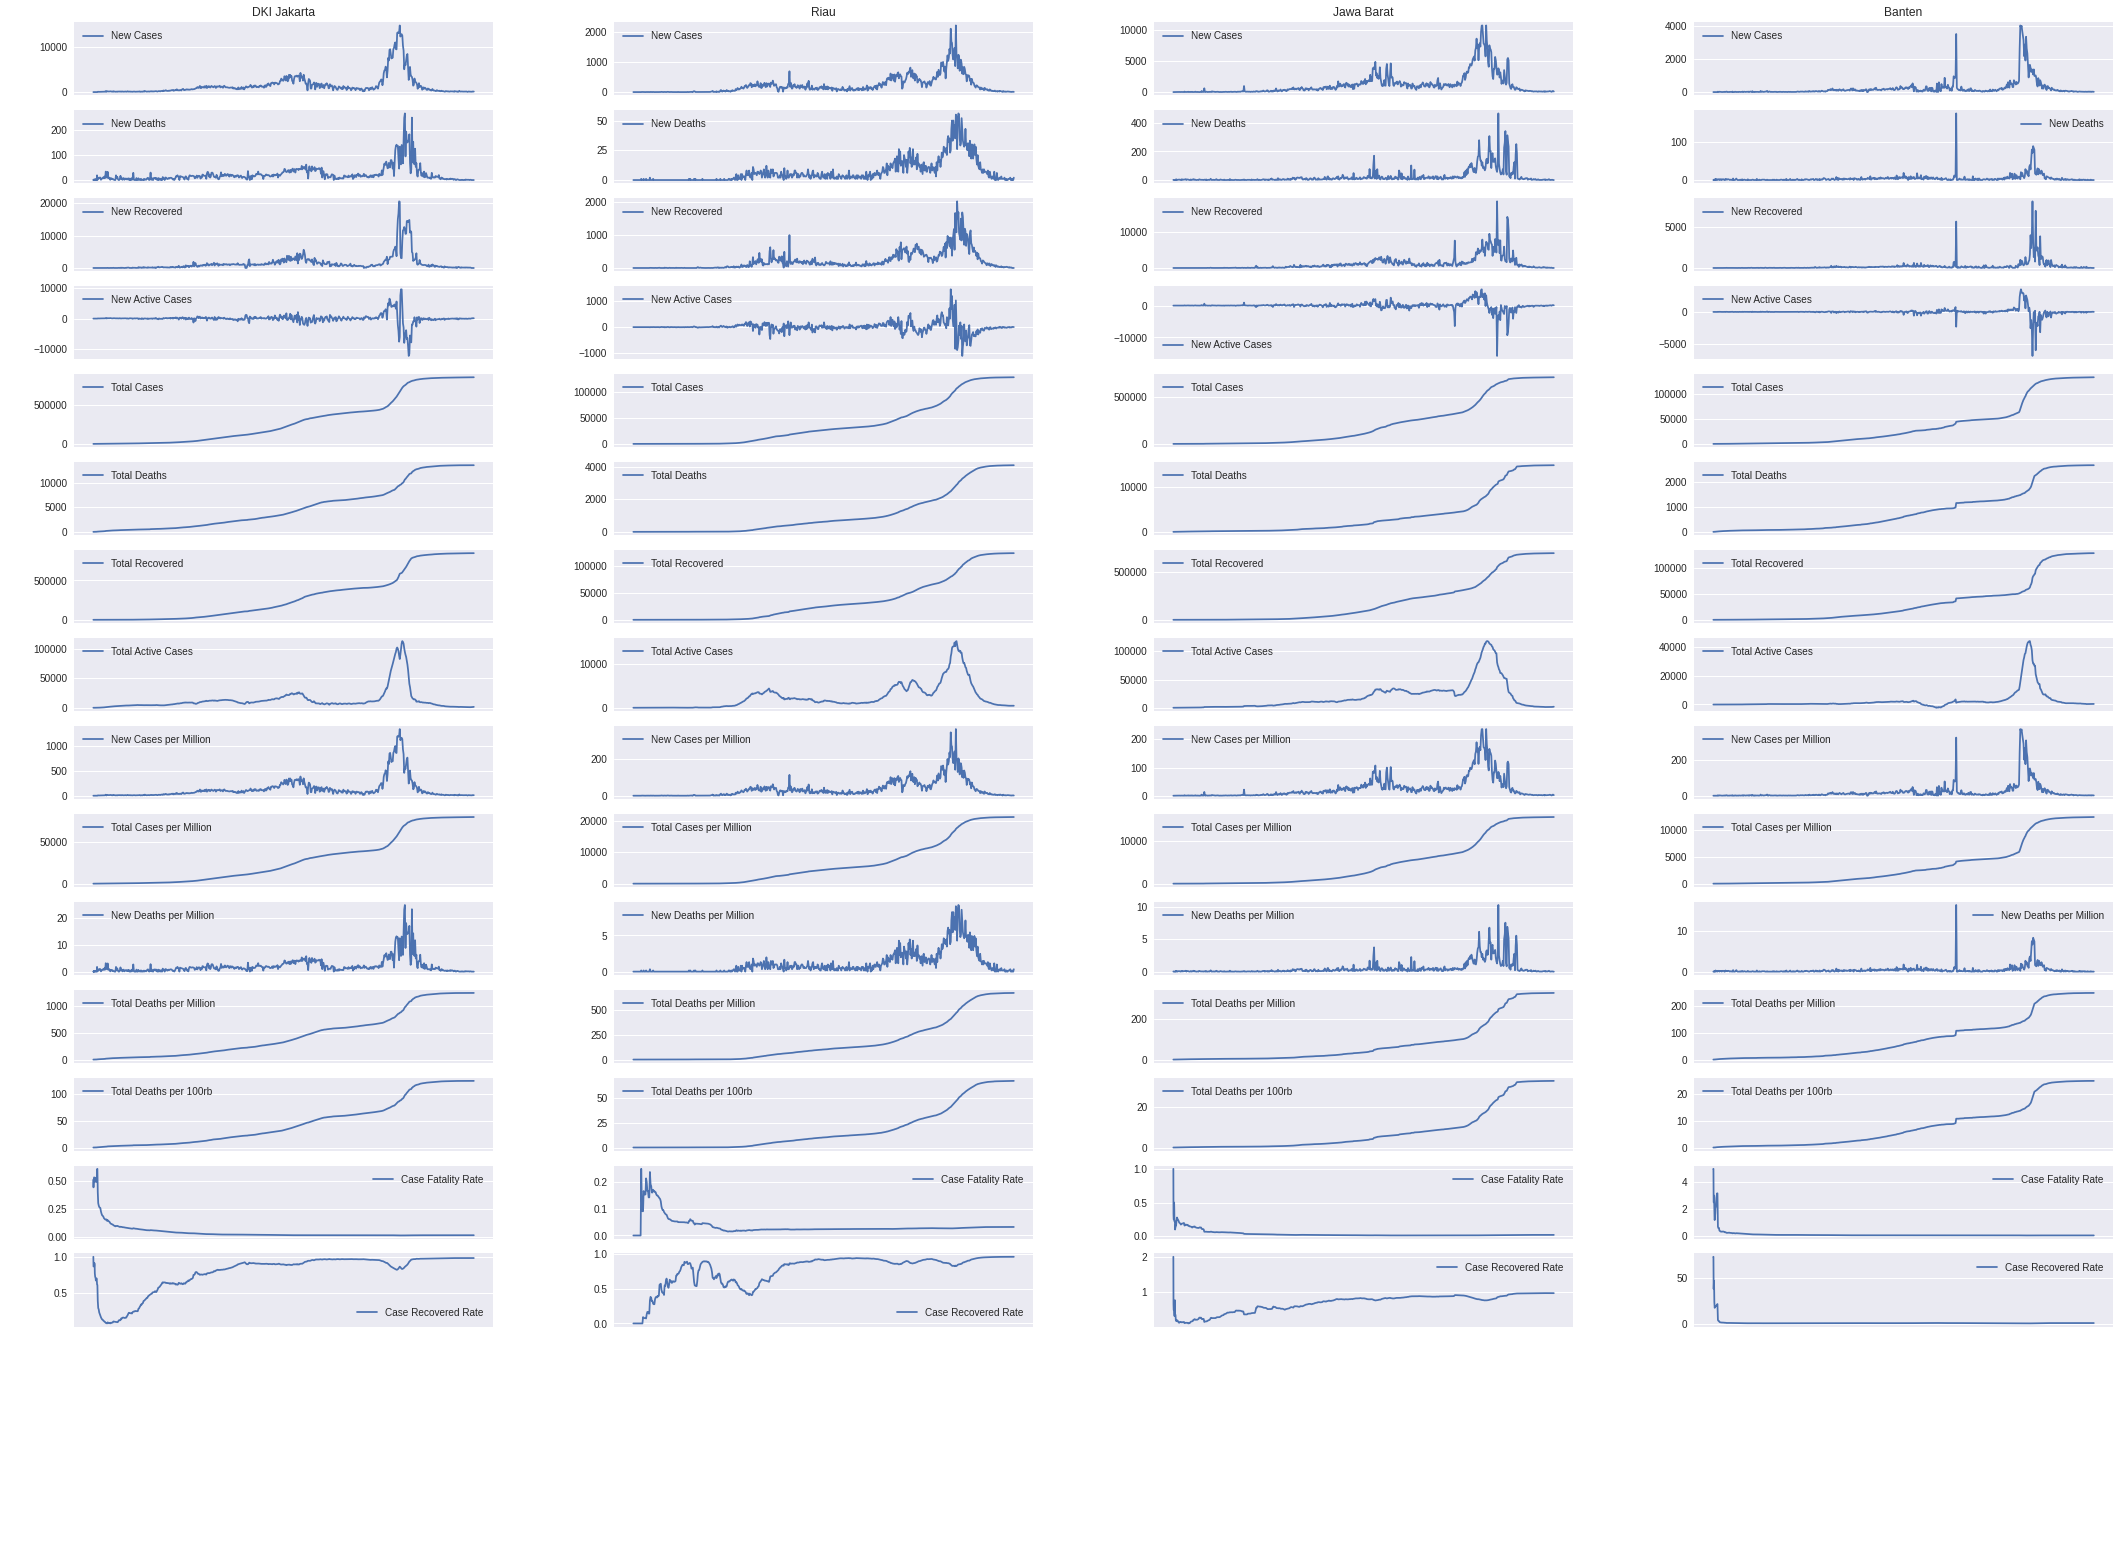

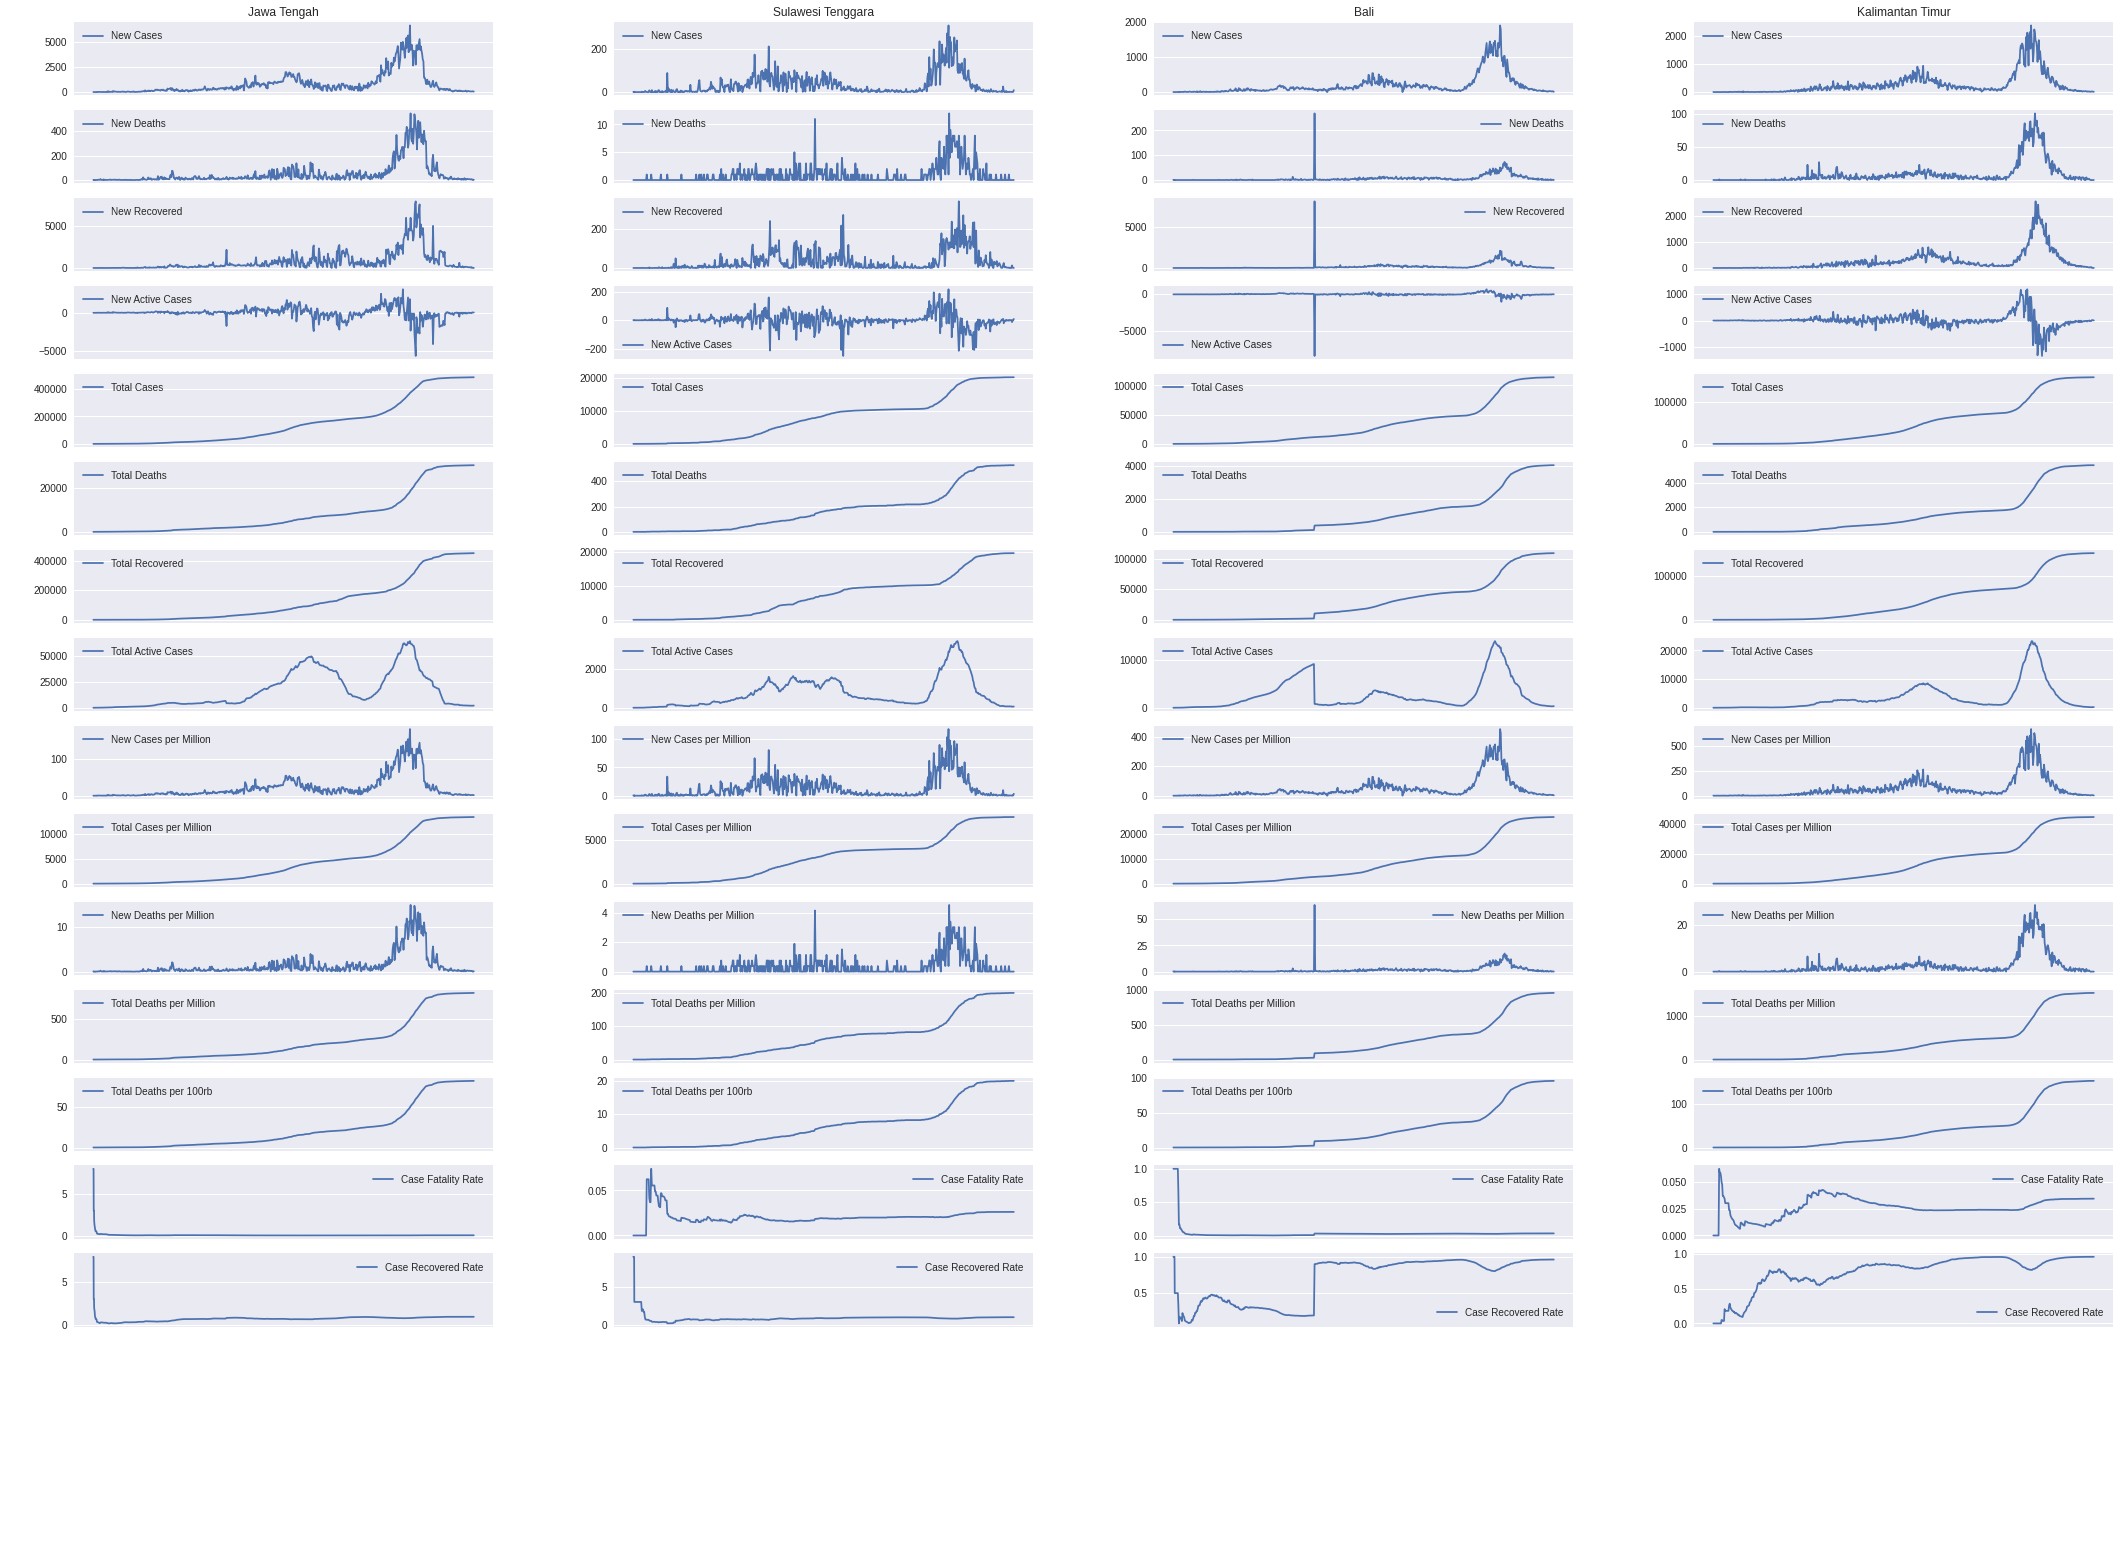

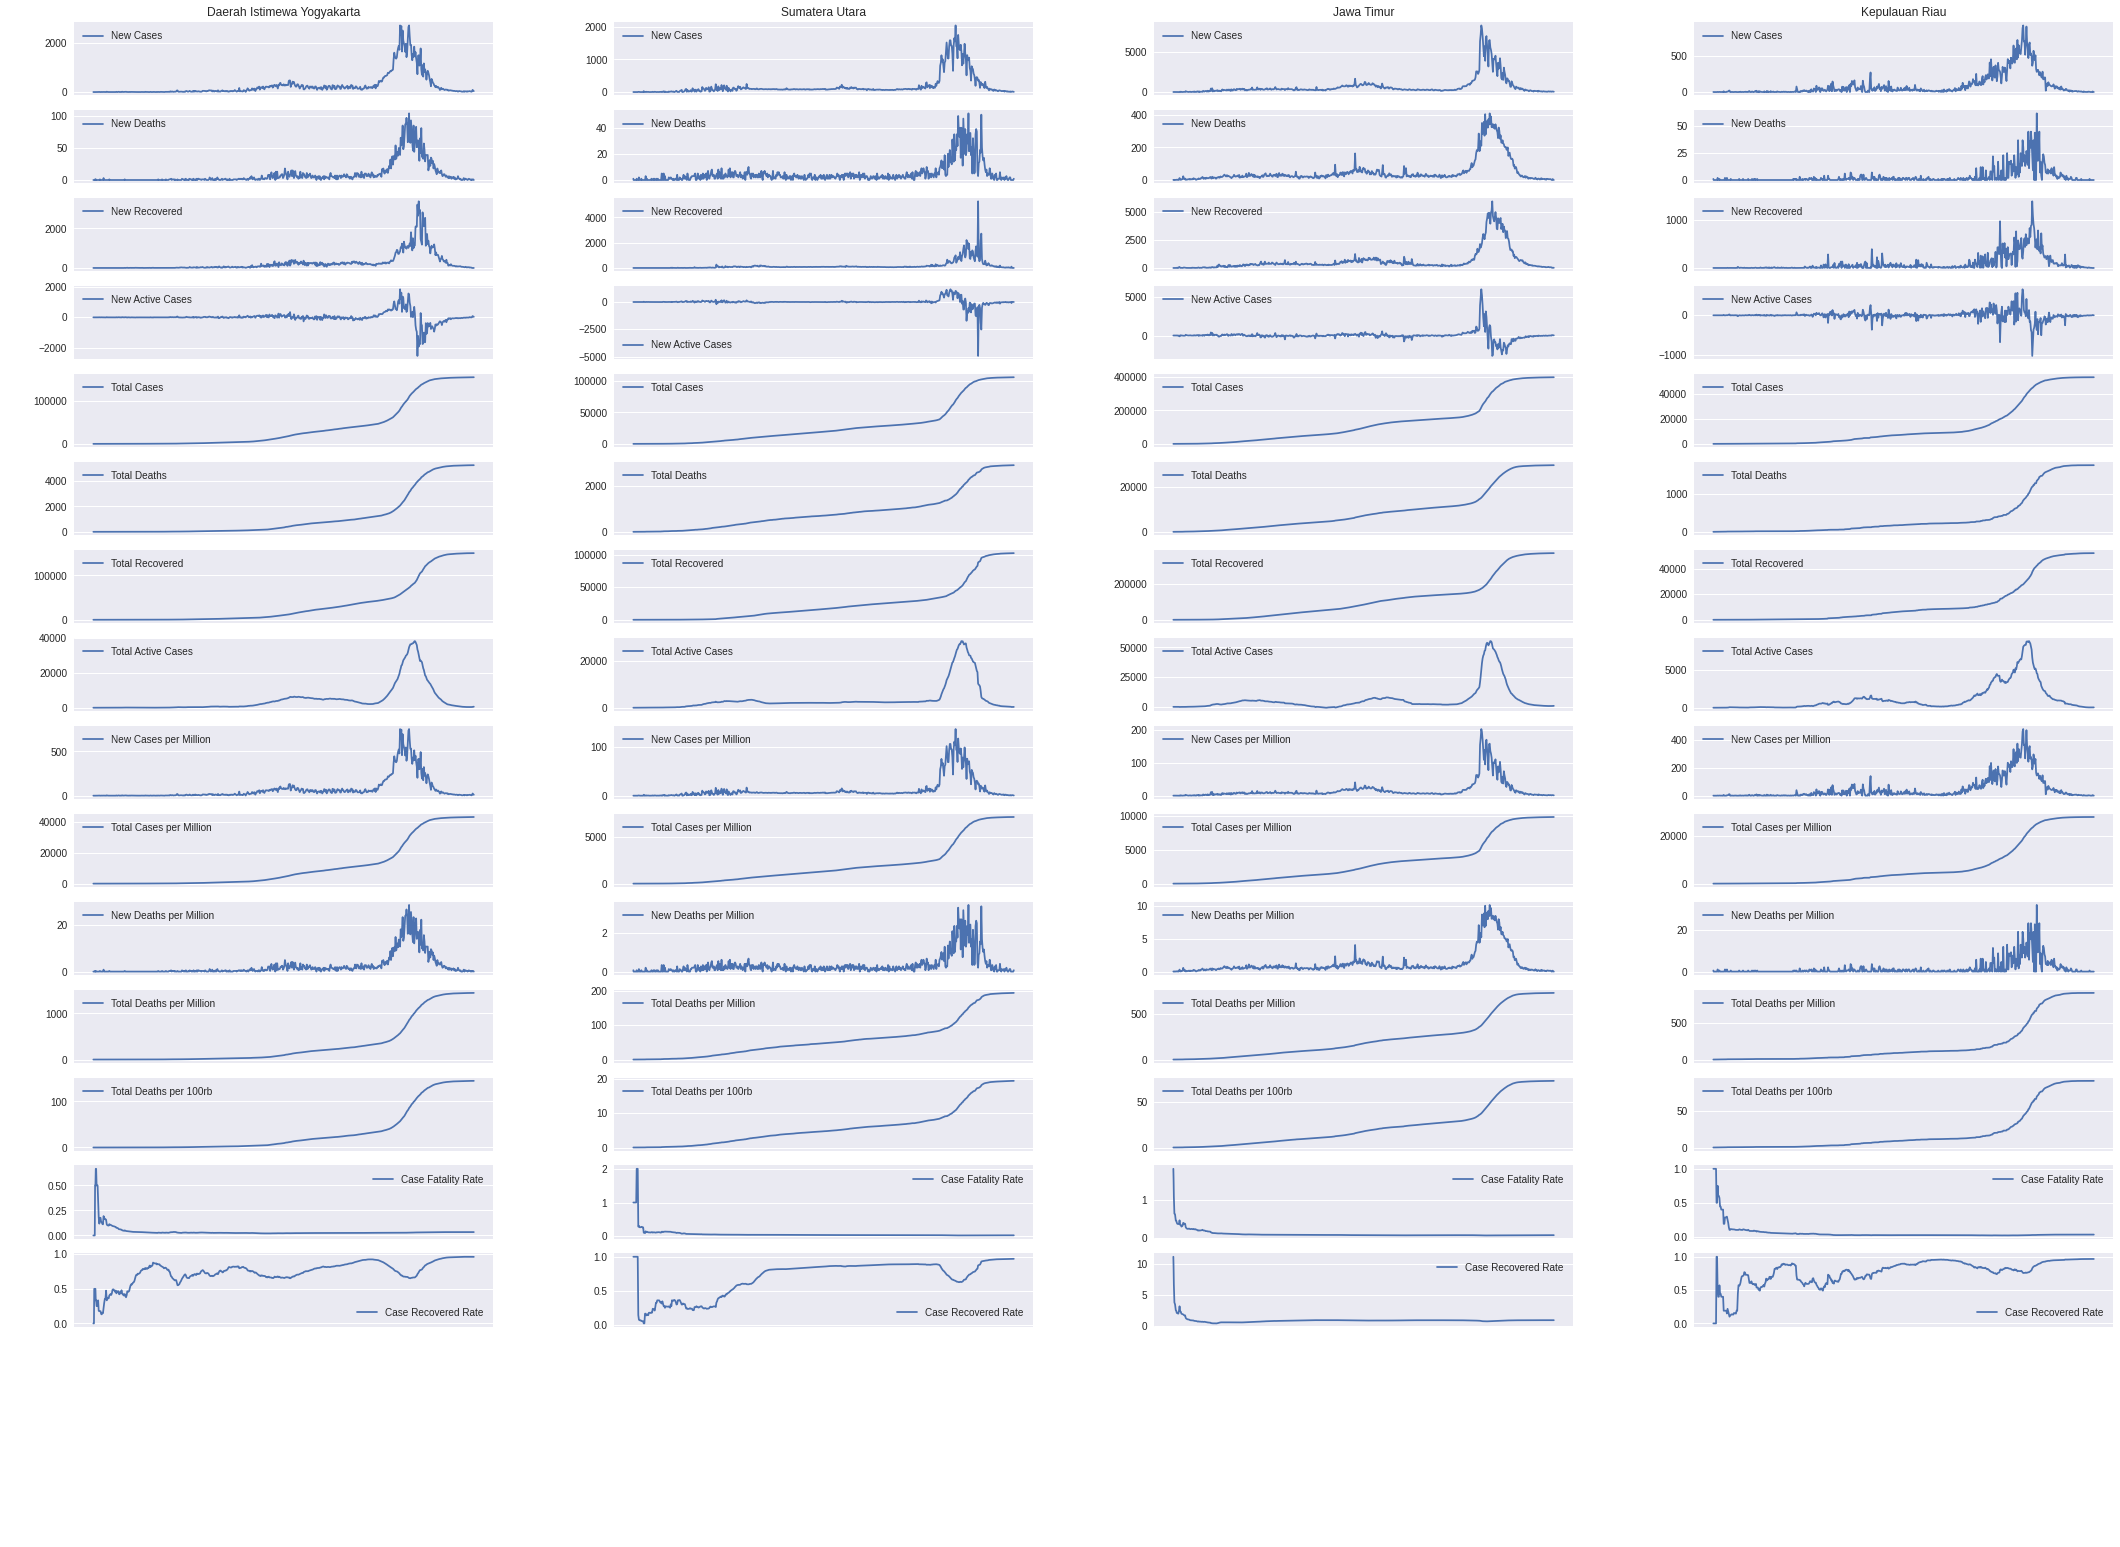

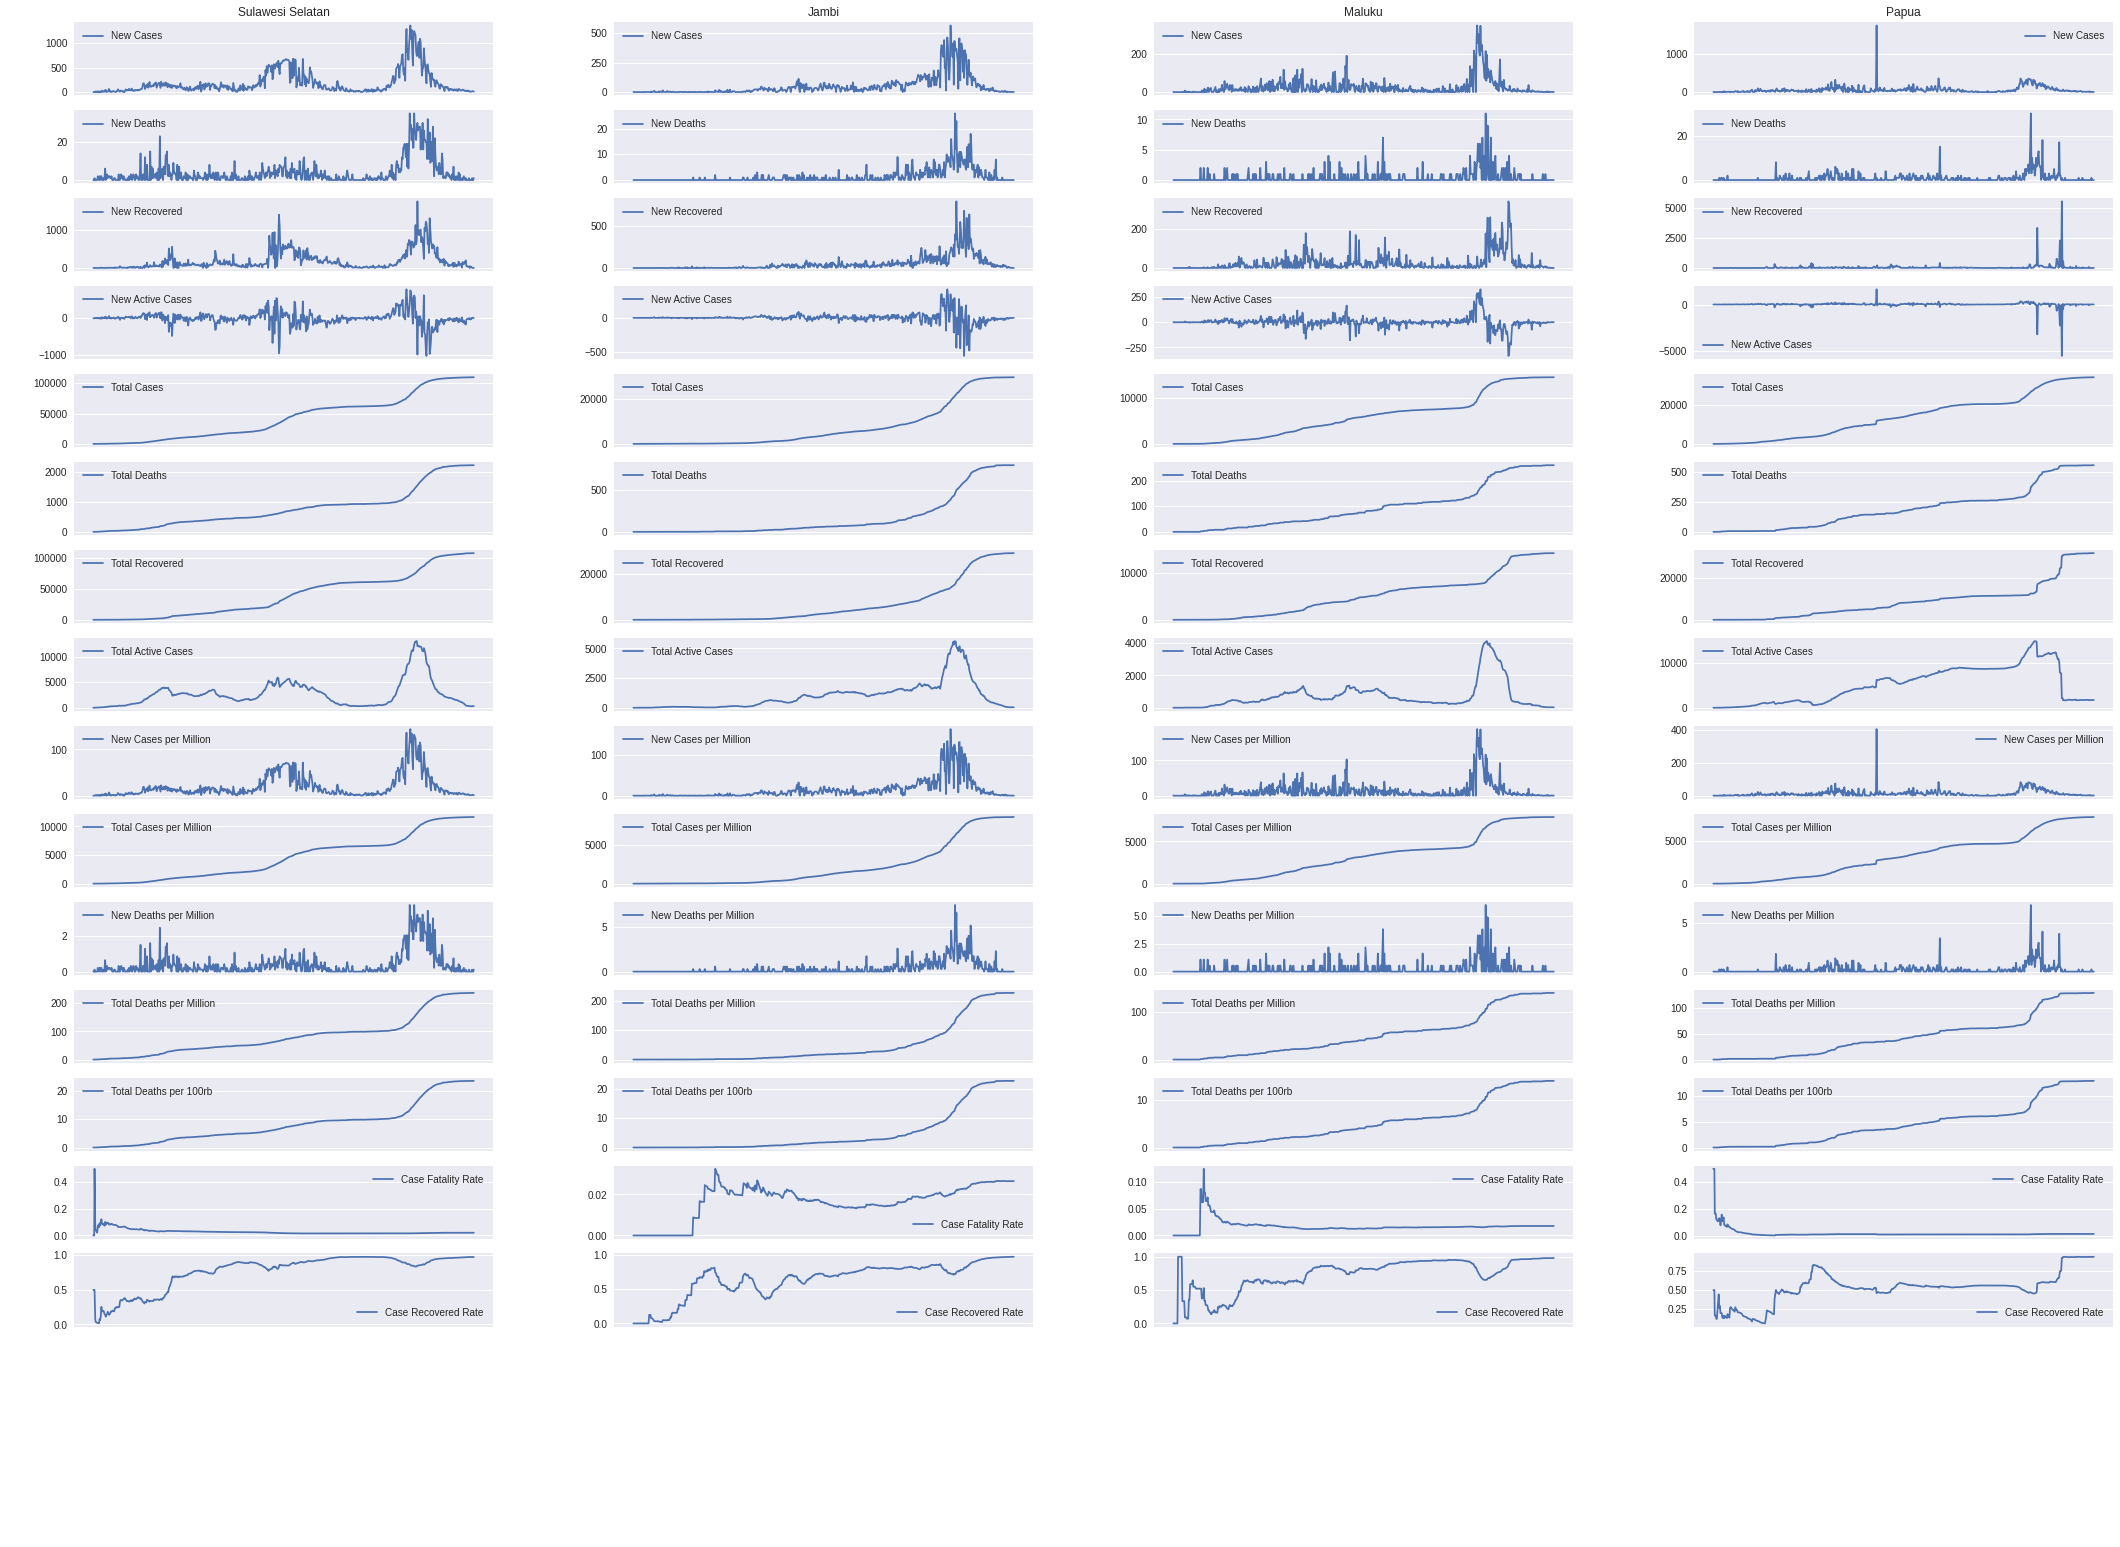

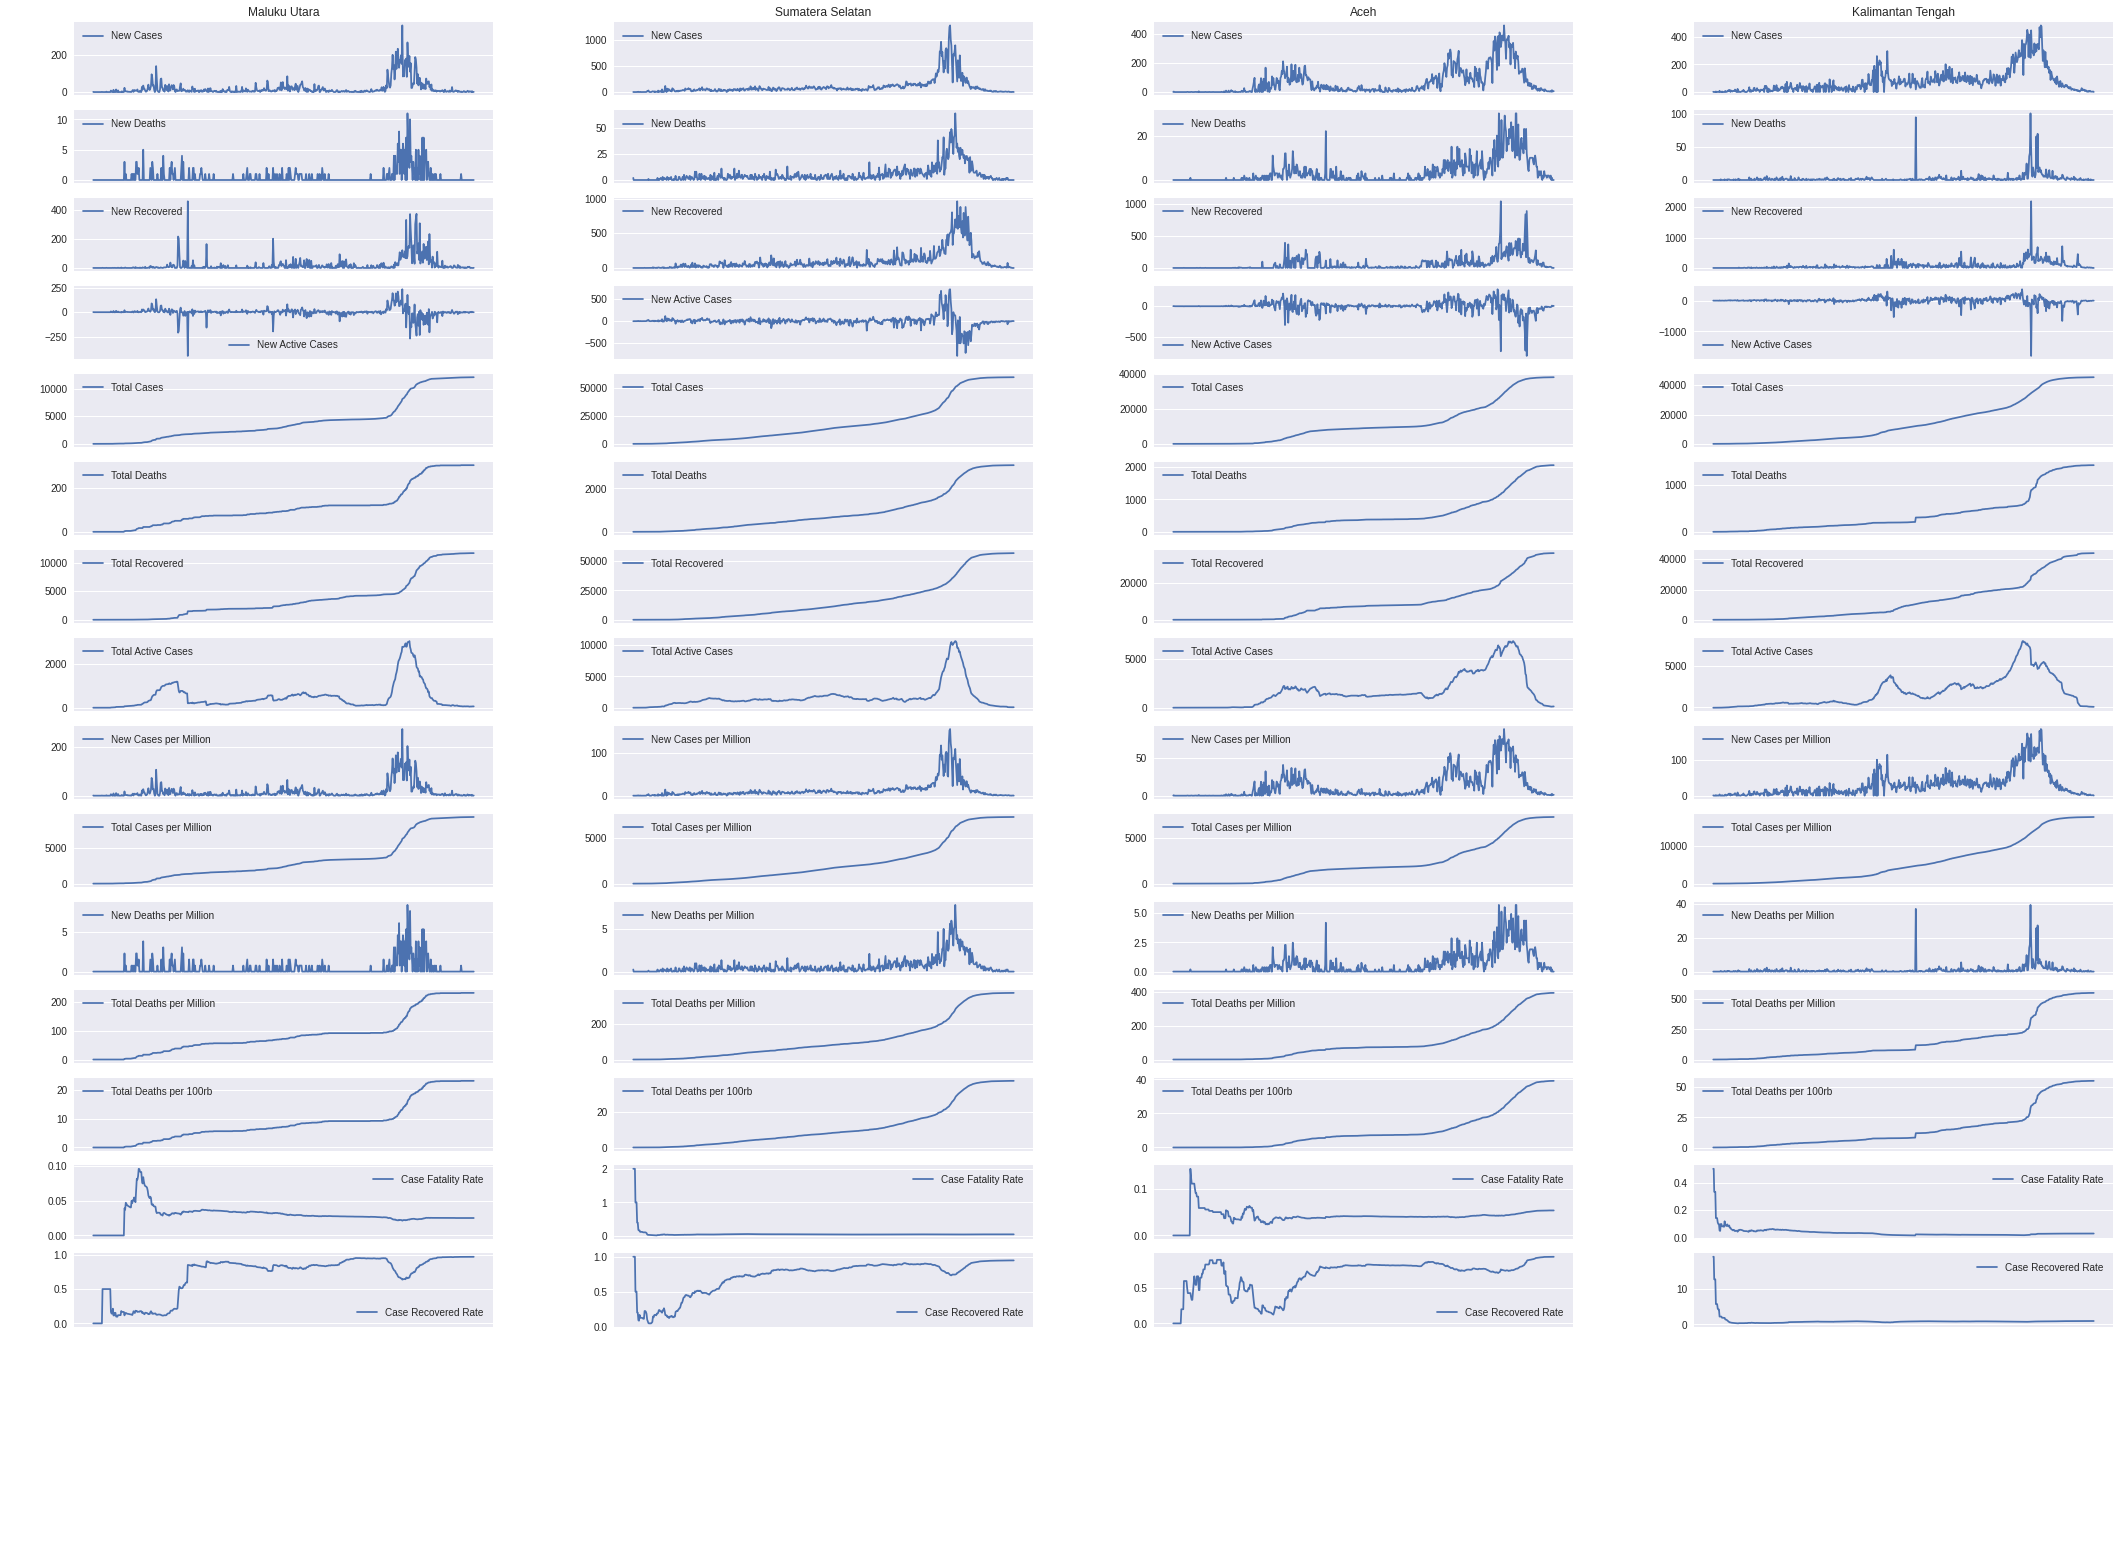

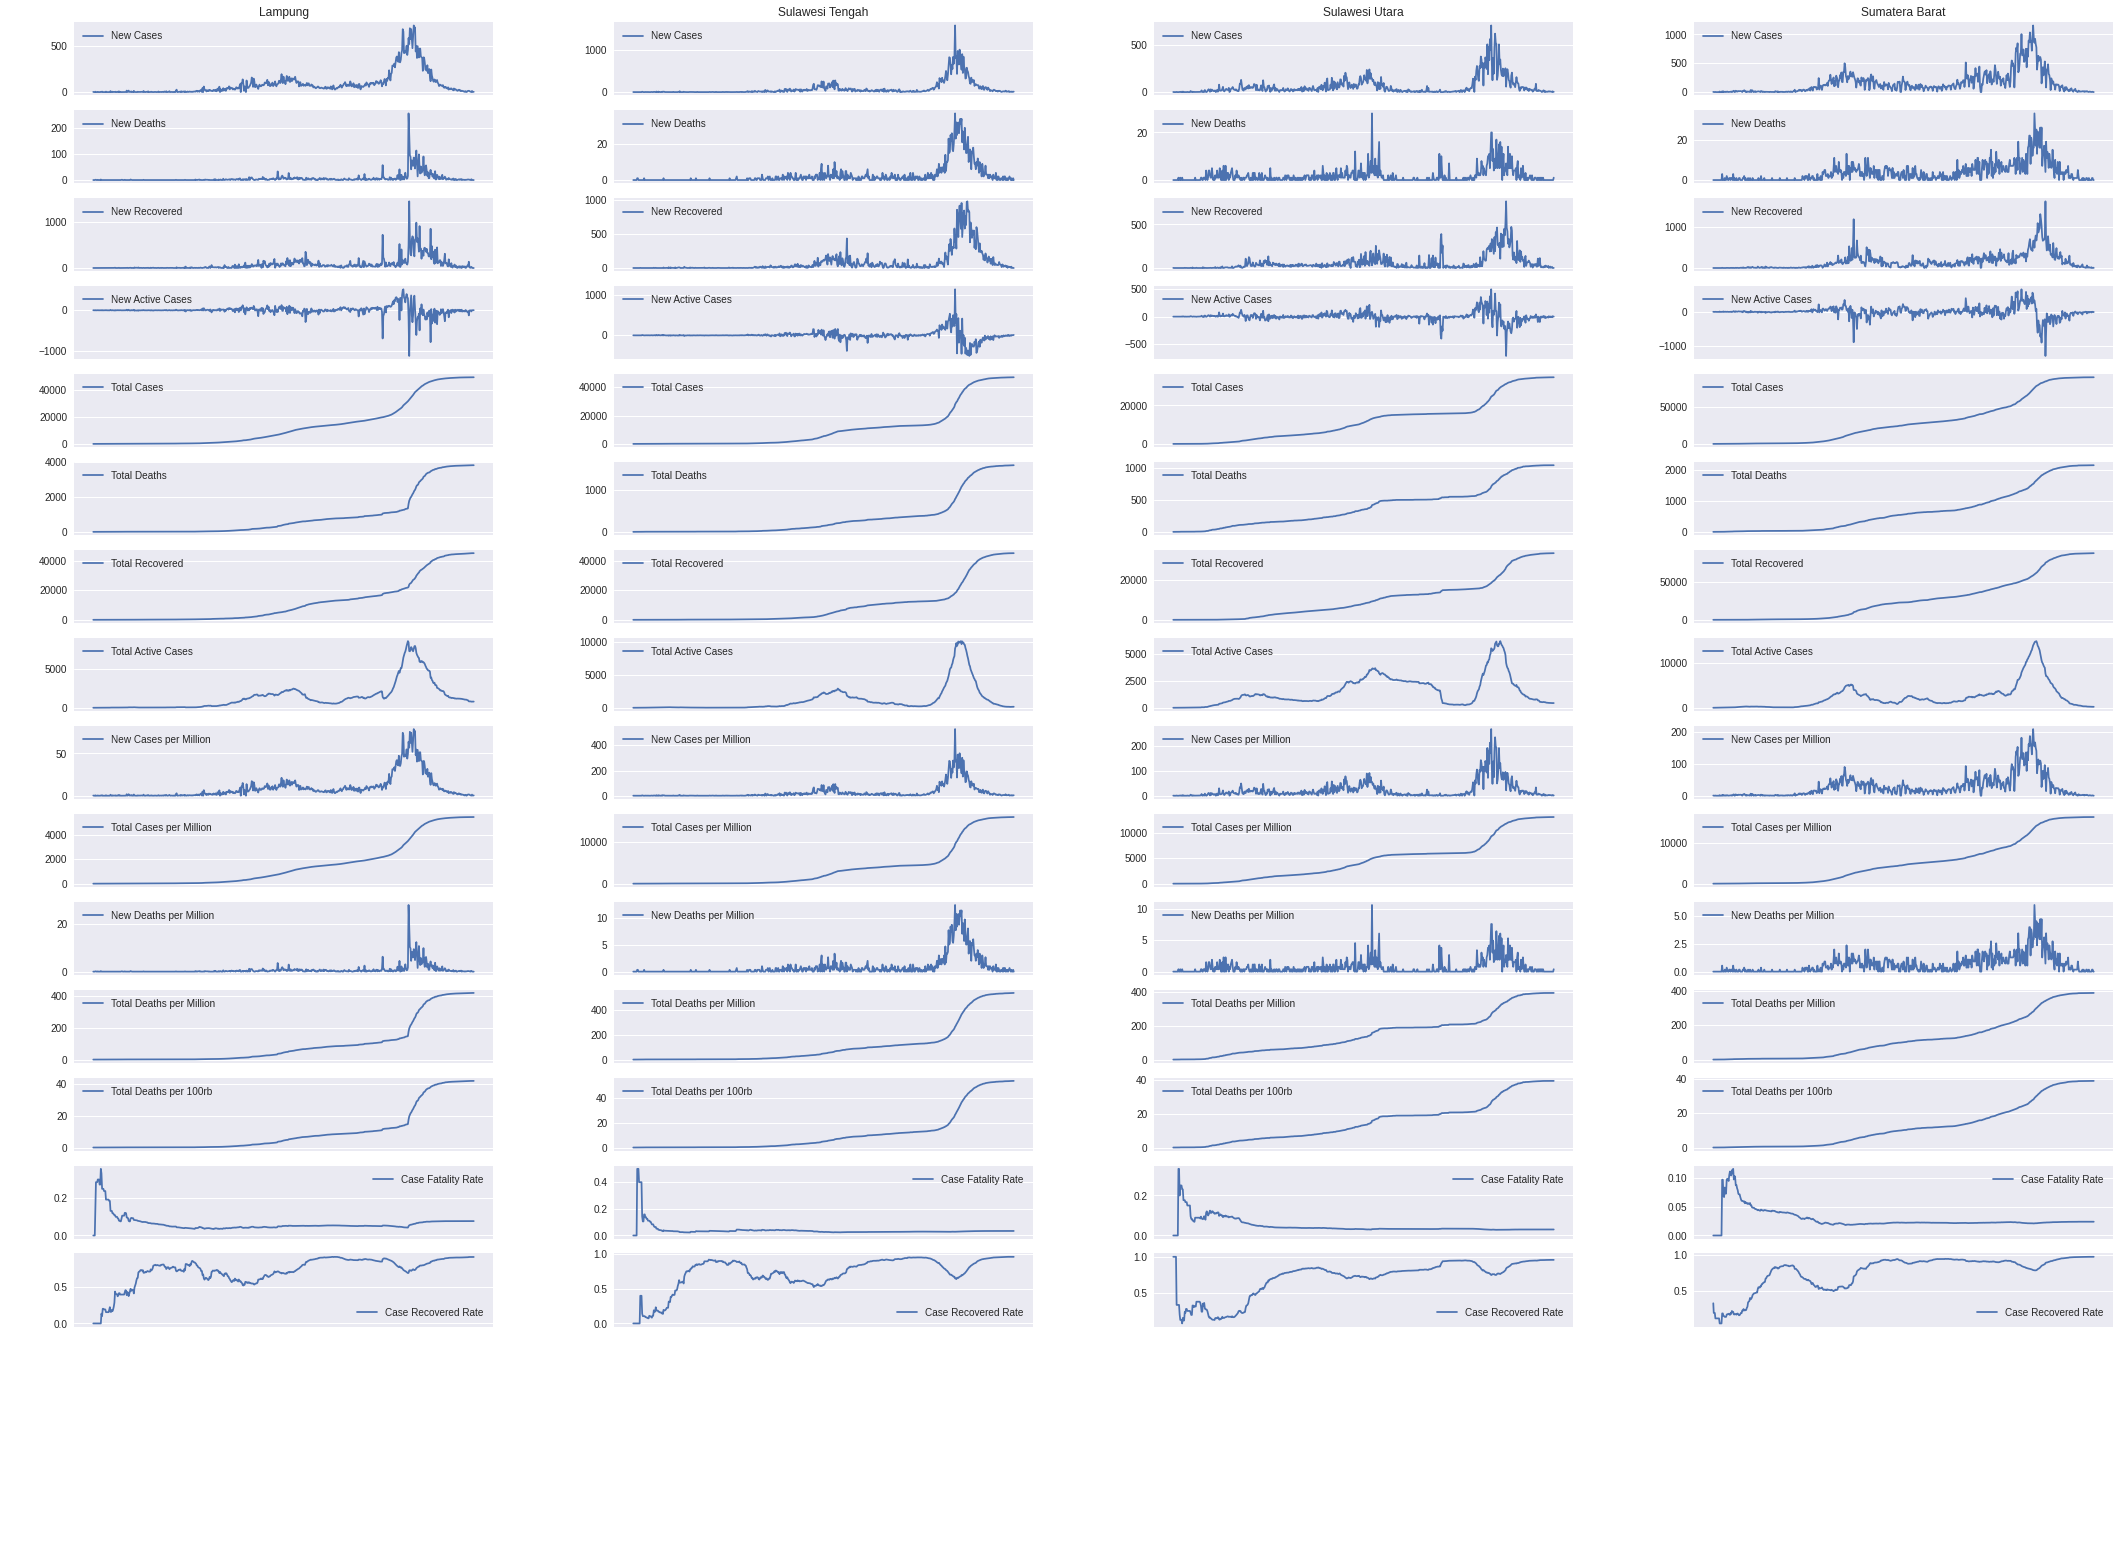

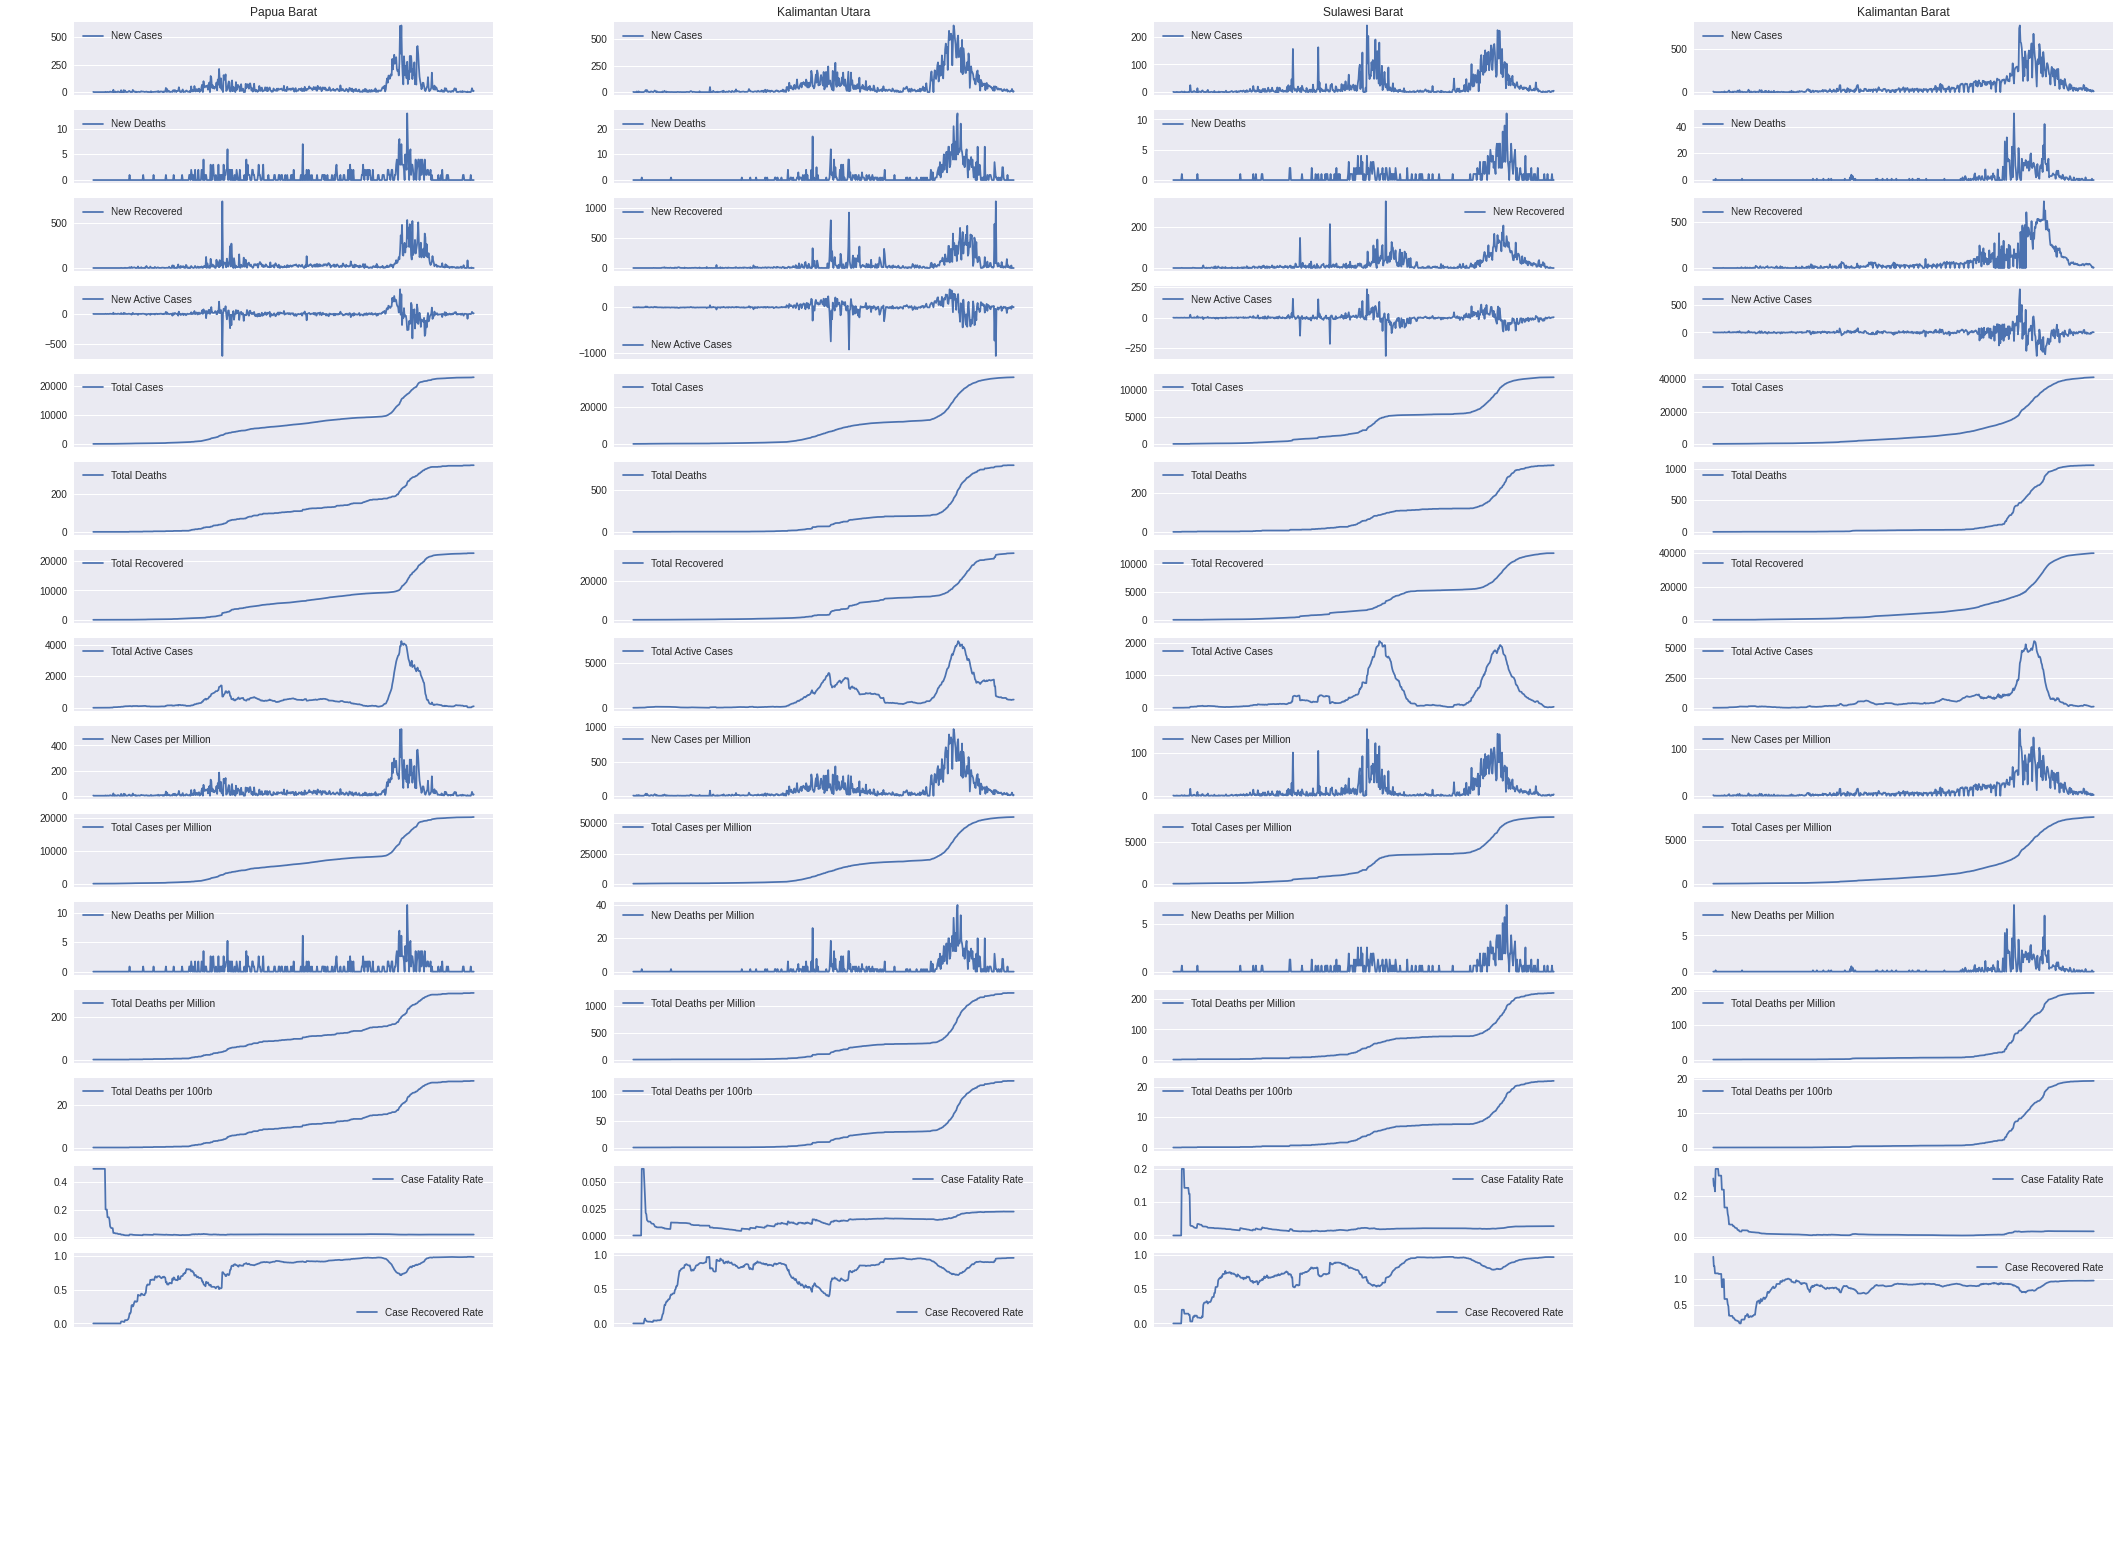

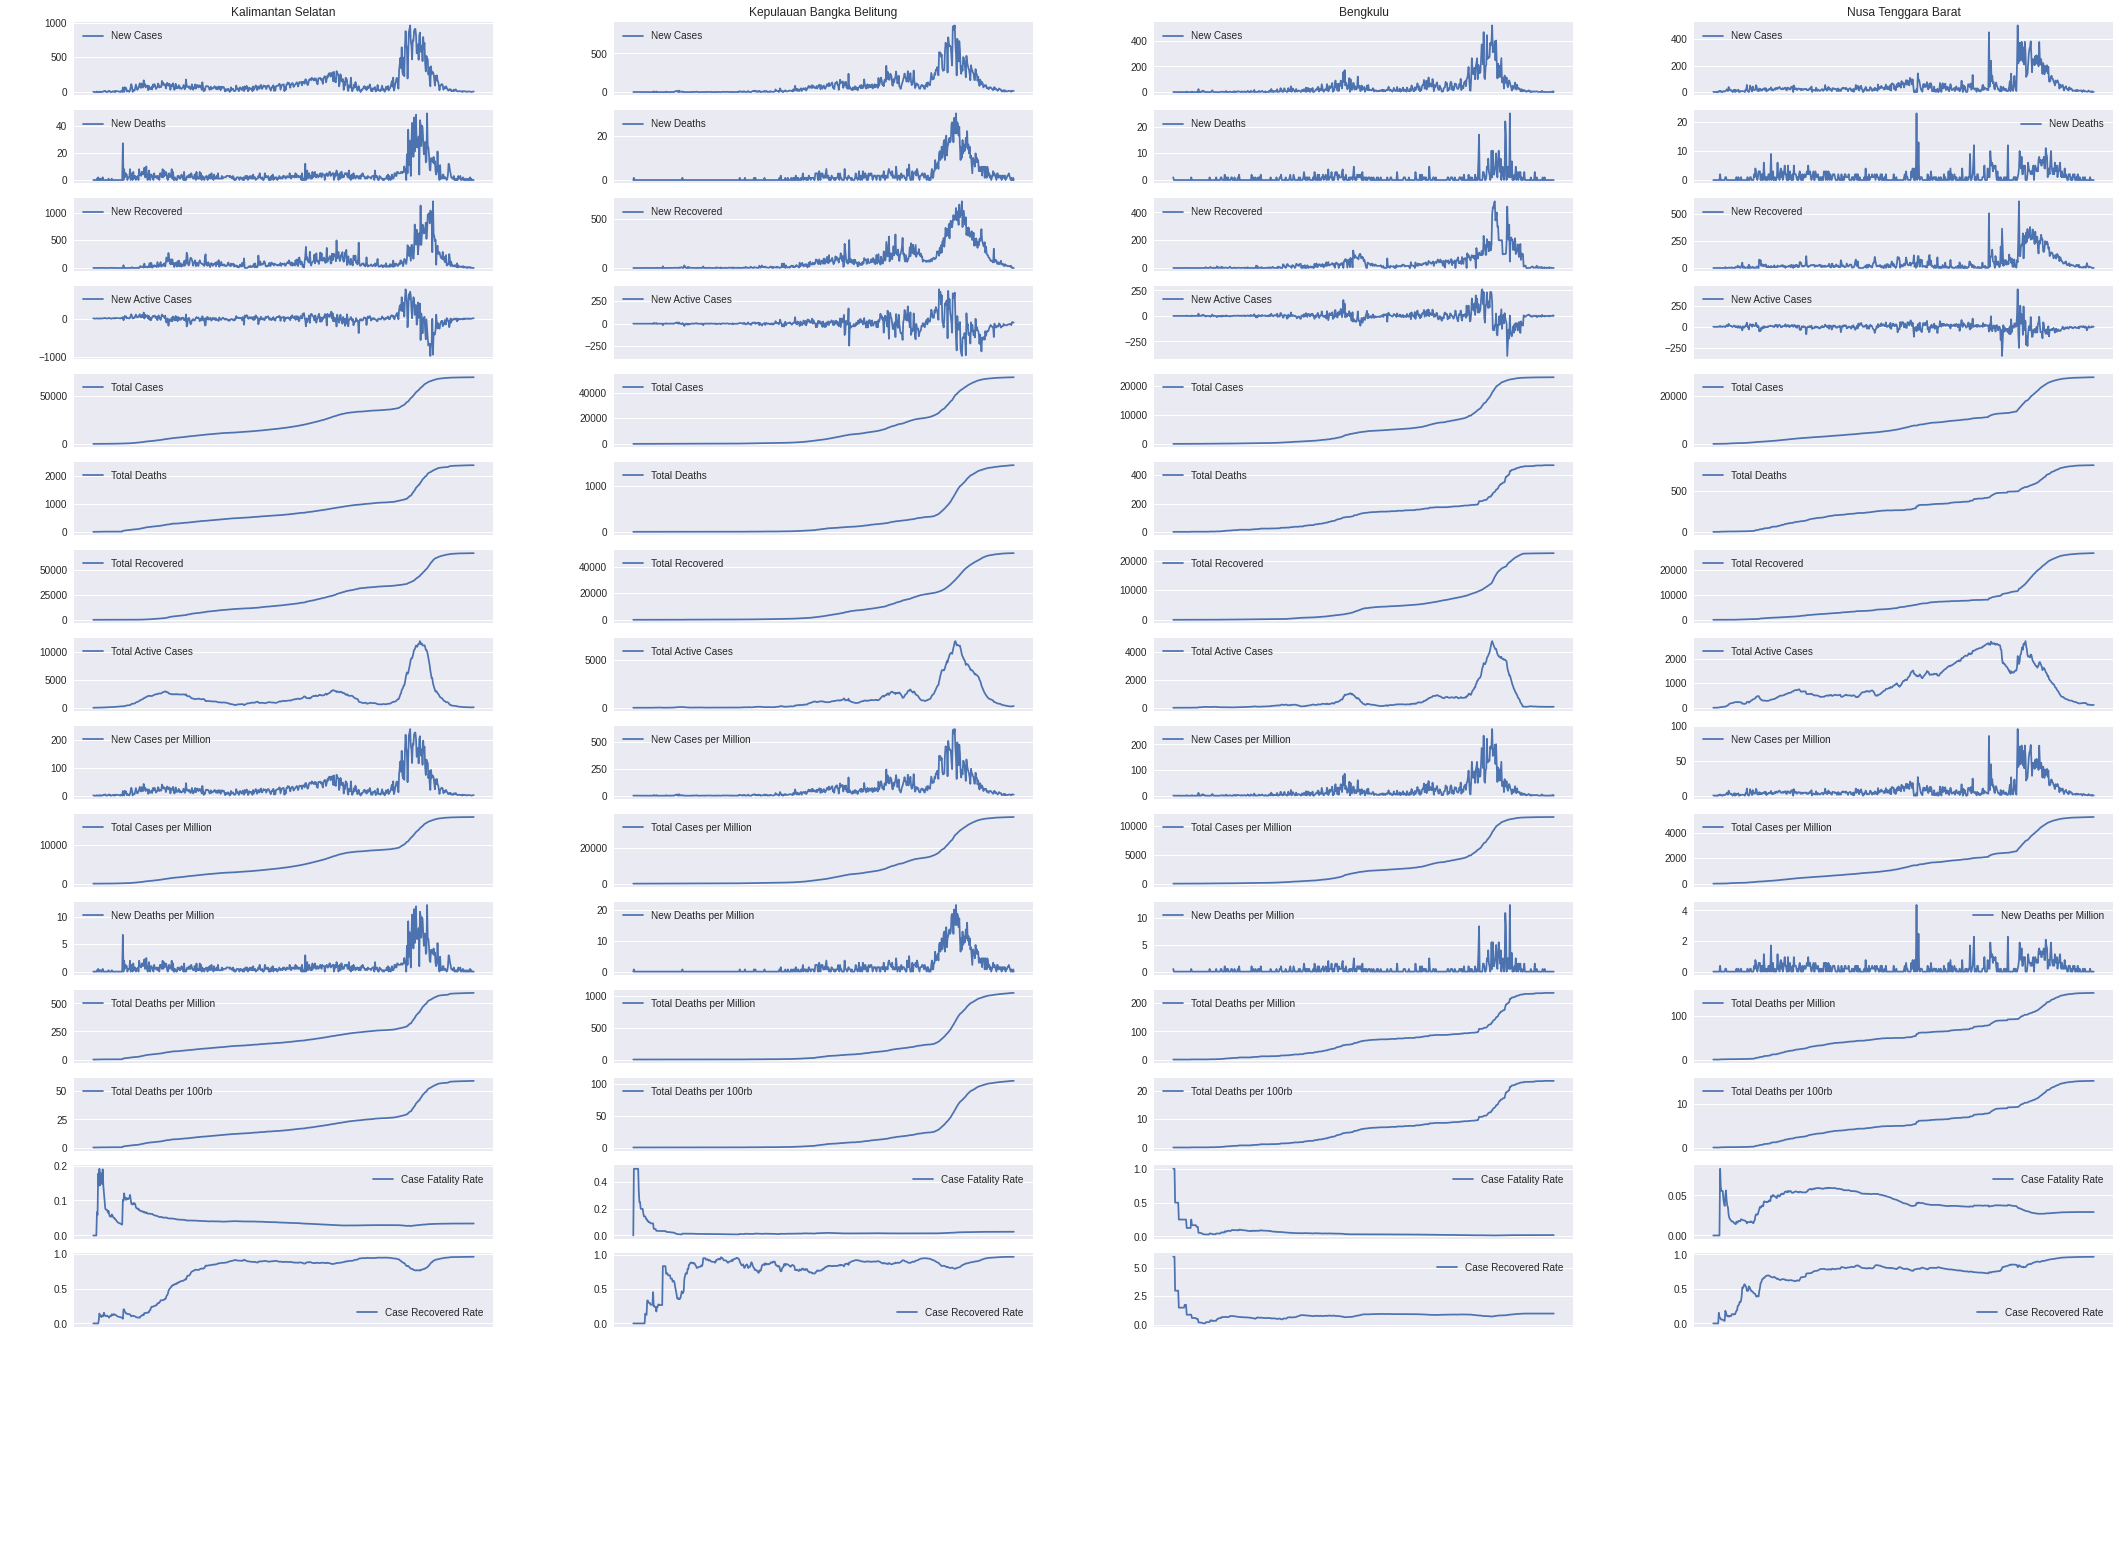

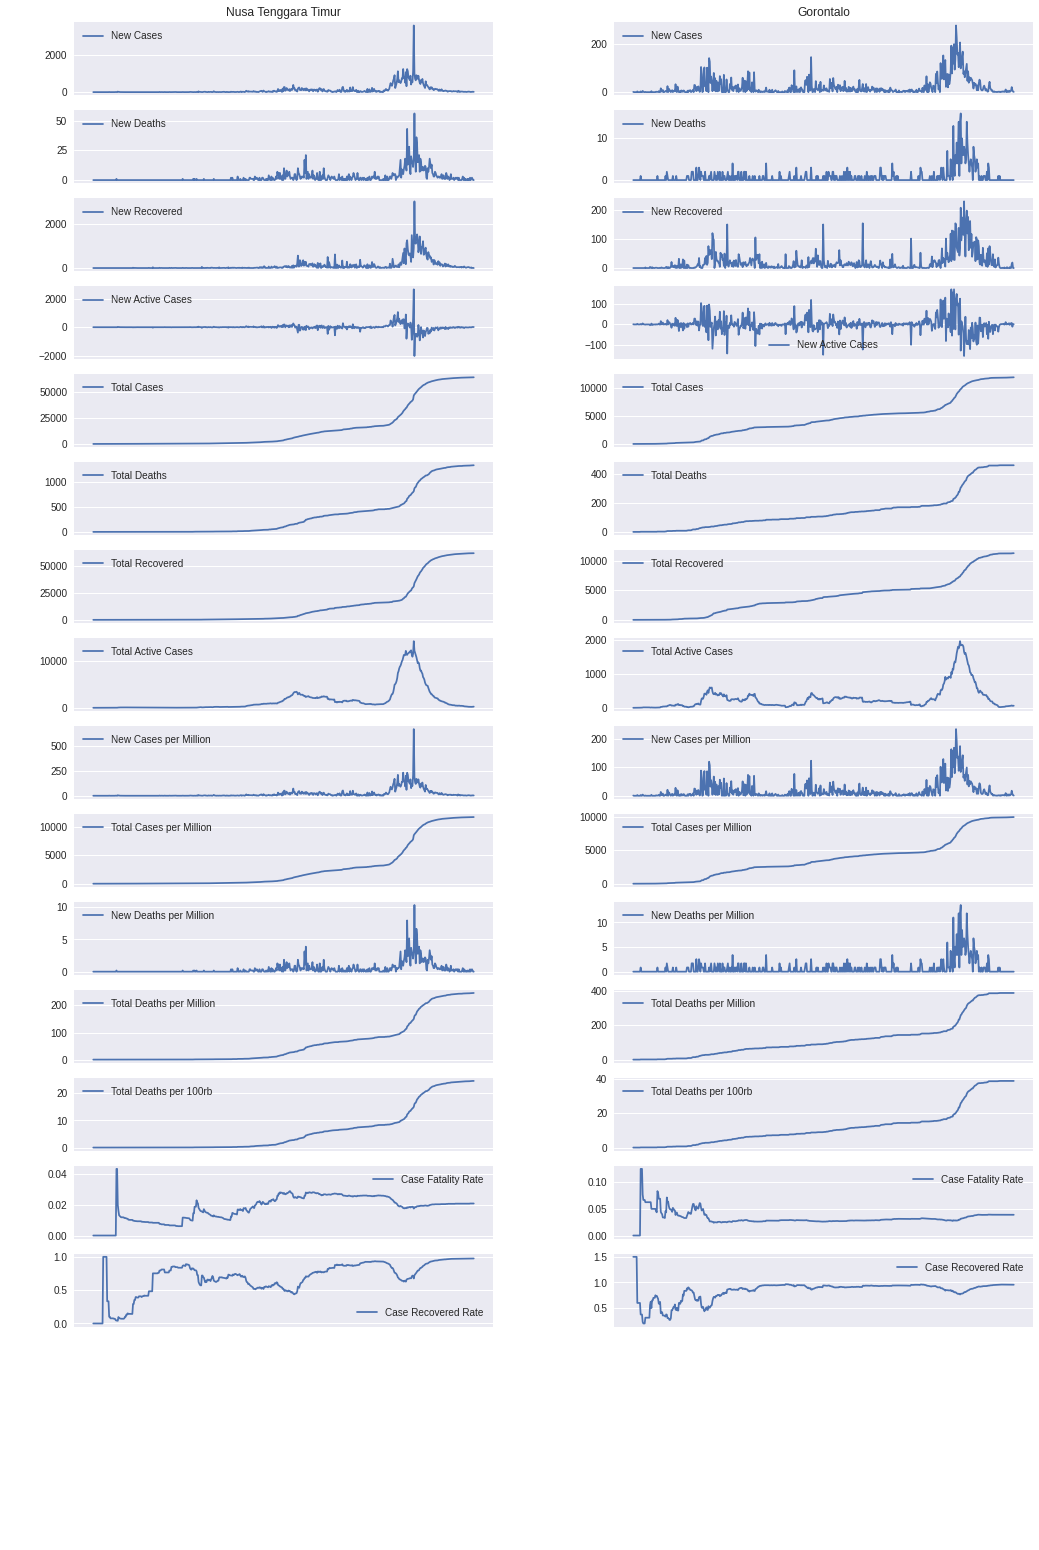

In [ ]:
columnsToPlot = ['New Cases',	'New Deaths',	'New Recovered',	'New Active Cases',	'Total Cases',	'Total Deaths',	'Total Recovered',	'Total Active Cases',	'New Cases per Million',	'Total Cases per Million',	'New Deaths per Million',	'Total Deaths per Million',	'Total Deaths per 100rb',	'Case Fatality Rate',	'Case Recovered Rate']

plotScale = 6
mpl.rcParams['figure.figsize'] = (5*plotScale, 4*plotScale)

listOfLocations = df['Location'].unique()
numOfCol = 4

#nda sangka kalo ba plotting di matplotlib itu pica-pica ontak :')

#kase bagi tiap baris 4 kolom
for locGroup in range(0, len(listOfLocations), numOfCol):
  #bekeng figure baru tiap baris
  fig = plt.figure(constrained_layout=False)

  #subfigure yang ba panjang ke kanan
  subplots = fig.subfigures(1,4)

  #listOfLocations[locGroup:locGroup + numOfCol]
  #
  #maksudnya slice tu array listOfLocations, mulai dari index locGroup, sampe index locGroup + numOfCol
  #jadi nanti depe elemen maximum ada 4
  for idxLoc, location in enumerate(listOfLocations[locGroup:locGroup + numOfCol]):
    #filter data cuma for itu lokasi
    df1 = df[df['Location'] == location]
    df1.sort_values('Date')
    #bekeng subplot yang ba panjang ke bawah for mo se tunjung dpe graf
    ax = subplots[idxLoc].subplots(len(columnsToPlot), 1)

    #mulai enumerasi tiap nilai dari dataset, kong se muncul di graf satu satu
    #
    #variabel 'ax' itu berupa list yang ada subaxes for torang mo plot akang graf
    for idxCol, (axes, columns) in enumerate(zip(ax, columnsToPlot)):
      #ba cit, bekeng supaya graf pertama se muncul title
      if idxCol == 0:
        axes.set_title(location)

      #plot graf di 'axes' itu
      axes.plot(df1[columns], label=columns)
      axes.get_xaxis().set_ticks([])
      axes.legend()

Berdasarkan visualisasi diatas, penulis menemukan data dari beberapa provinsi yang memiliki anomali

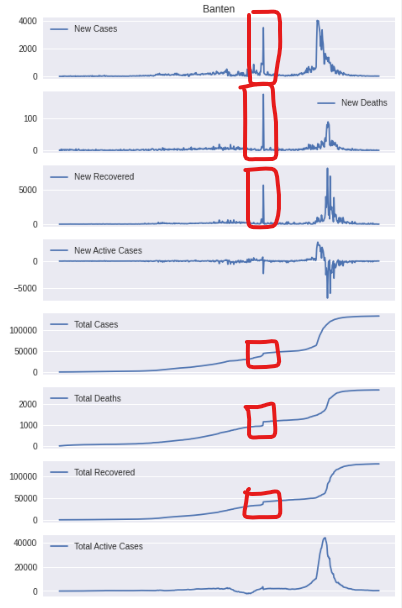
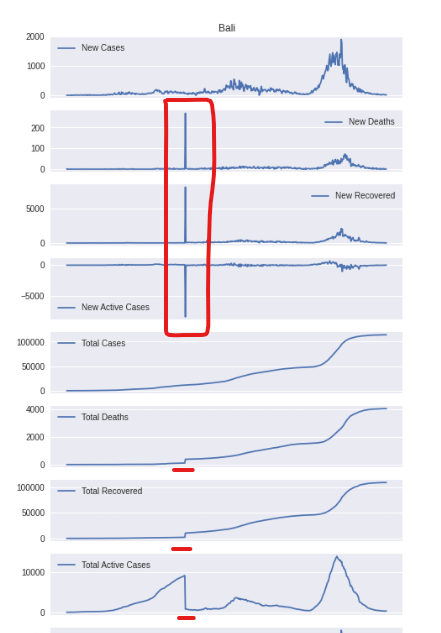
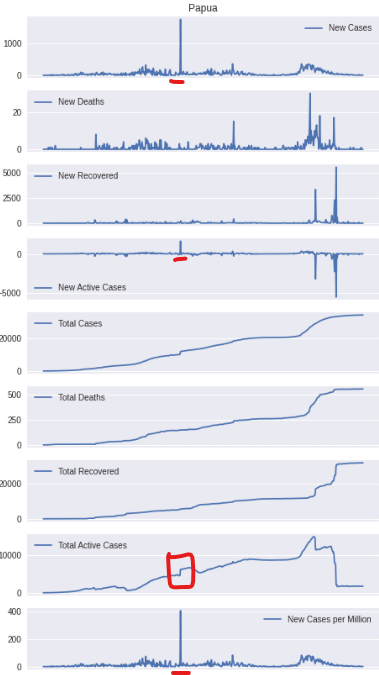

Berdasarkan insight tersebut, penulis tidak akan mengambil data dari provinsi tersebut sebagai data input yang nantinya akan digunakan sebagai sumber data untuk Forecasting.

# Exploratory Data Analysis

Pada tahap ini, dilakukan analisa secara visual dengan cara mengeksplorasi data dalam kolom-kolom guna menemukan wawasan baru dari dataset tersebut.

Dalam hal ini, penulis tertarik untuk melihat provinsi mana yang memiliki Total Recovery yang tertinggi. Akan tetapi, penulis ingin melihat data tersebut dengan ukuran relatif terhadap populasi dari provinsi tersebut, ini karena penulis ingin menghindari ranking Total Recovery yang membias ke provinsi yang berpendudukan padat. Dengan menggunakkan pengukuran relatif terhadap populasi setiap provinsi tersebut, ranking akan dirasa lebih fair dalam menunjukkan provinsi mana yang memiliki Total Recovery tertinggi

Text(0, 0.5, 'Persentase')

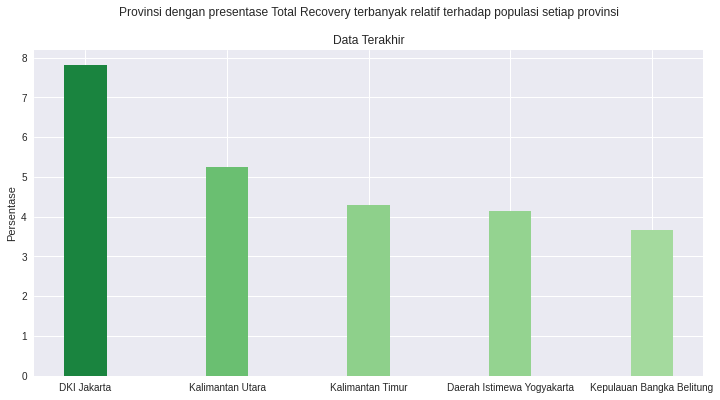

In [ ]:
totalRecoveredDf = df[['Date', 'Location', 'Total Recovered', 'Population']].groupby(['Location']).last()

#bagi tu total recovered deng populasi
for row in totalRecoveredDf.iterrows():
  totalRecoveredDf.at[row[0], 'Total Recovered'] = (row[1]['Total Recovered'] / row[1]['Population']) * 100

#ator depe ukuran plotting
plotScale = 6
mpl.rcParams['figure.figsize'] = (2*plotScale, 1*plotScale)

#bekeng bar plot
figure, axes = plt.subplots(1, 1)

#pemetaan skalar supaya boleh se warna tu bars
scalarMap = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=10), cmap=plt.get_cmap('Greens'))

#iterasi tu 5 provinsi teratas berdasarkan total recovered, se muncul jadi bar 
for elem in totalRecoveredDf.sort_values('Total Recovered', ascending=False).reset_index().head(5).iterrows():
  axes.bar(elem[1]['Location'], elem[1]['Total Recovered'], color=scalarMap.to_rgba(elem[1]['Total Recovered']), width=0.3)

axes.set_title('Provinsi dengan presentase Total Recovery terbanyak relatif terhadap populasi setiap provinsi\n\nData Terakhir')
plt.ylabel("Persentase")

#uncomment ini baris code kalo nda mo se relatif dengan jumlah populasi
# df.groupby(['Location']).last().sort_values('Total Recovered', ascending=False).reset_index().head(5).plot.bar(x='Location', y='Total Recovered')

Berdasarkan visualisasi ranking diatas, ditemukan bahwa provinsi DKI Jakarta merupakan provinsi dengan Total Recovery tertinggi, yang diikuti oleh Kalimantan Utara, Kalimantan Timur, DIY, dan Kepulauan Bangka Belitung.

Ini menunjukkan bahwa provinsi DKI Jakarta memiliki penanganan covid-19 yang dirasa lebih baik daripada provinsi yang lain, ditunjukkan dari Total Recovery tertinggi yang mengindikasikan bahwa fasilitas kesehatan dan perawatan di provinsi tersebut berjalan efektif dalam menurunkan jumlah pengidap Covid-19 dengan memastikan kesembuhan total yang baik daripada setiap pengidap tersebut.

Mengikuti visualisasi sebelumnya, penulis ingin melihat ranking Total Recovery dari setiap provinsi dalam peta seluruh Indonesia guna menemukan titik fokus penanganan Covid-19 di Indonesia.

In [ ]:
#se kelompok per provinsi ('Location') kong ambe nilai max khusus for 'Total Recovered'
totalSembuhSeindonesia = df[['Location', 'Latitude', 'Longitude', 'Total Recovered']].groupby('Location').agg({
    'Latitude': 'first',
    'Longitude': 'first',
    'Total Recovered': 'max'
})

#muat tu peta dari google drive
modelGeografi = gpd.read_file('drive/MyDrive/dsp/gadm36_IDN_3.shp')
modelGeografi = modelGeografi.drop(columns=['NAME_0'])

#kolom provinsi ('Location') di peta depe nama 'NAME_1', torang rubah
modelGeografi = modelGeografi.rename(columns={'NAME_1' : 'Location'})

#khusus for provinsi DKI jakarta, depe nama di dataset peta itu 'Jakarta Raya', torang rubah
modelGeografi['Location'] = modelGeografi['Location'].replace({'Jakarta Raya' : 'DKI Jakarta'})

#join tu data peta dengan data total sembuh
pemetaanCovid = modelGeografi.merge(totalSembuhSeindonesia.sort_values(by='Location'), on='Location')

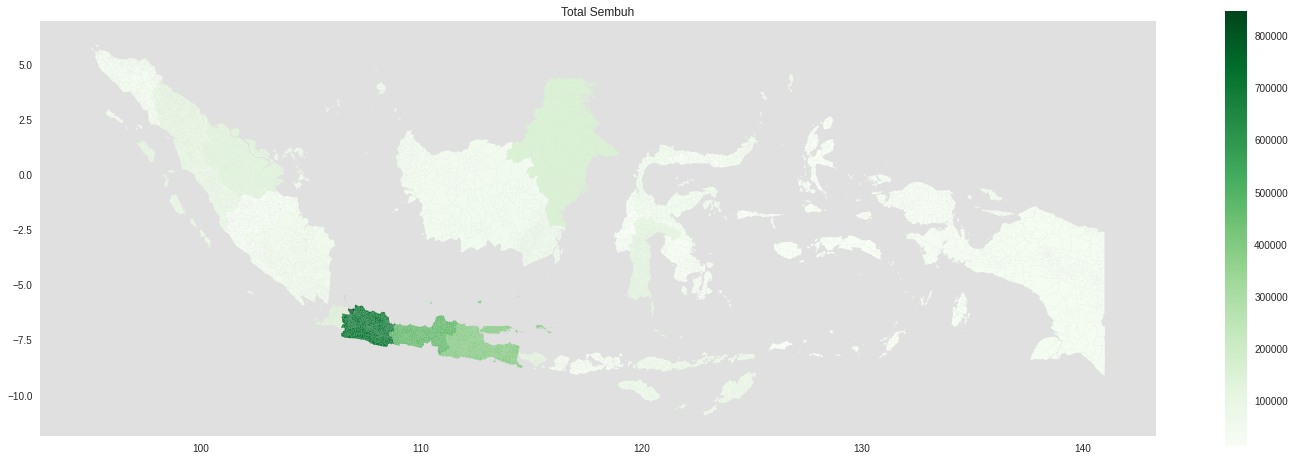

In [ ]:
figure, axes = plt.subplots(1, 1, figsize=(25, 8))
plt.style.use('seaborn')
pemetaanCovid.plot(column='Total Recovered', cmap='Greens', legend=True, ax=axes)
axes.set_title('Total Sembuh')
axes.set_facecolor('#E0E0E0')
axes.grid(False)

Berdasarkan visualisasi diatas, terlihat bahwa berdasarkan data sampai 5 November 2021 ini, penanganan covid-19 dengan Total Recovery tertinggi masih didominasi oleh provinsi di pulau Jawa.

# Forecasting dengan LSTM

Sekarang, dalam tahap ini, penulis tertarik untuk melakukan prediksi atau forecasting terhadap data-data Covid-19 yang disediakan oleh dataset ini

## Persiapan Dataset

Dalam hal ini, penulis memilih beberapa kolom yang akan dipakai sebagai ```features``` yang akan membantu model mempelajari dataset ini.

Dan untuk sumber data yang digunakan. Penulis menggunakkan data dari provinsi Sulawesi Utara karena penulis tidak menemukan outlier atau anomali dari data provinsi tersebut.

Date  New Cases  ...  Case Fatality Rate  Case Recovered Rate
259   2020-03-26        1.0  ...                0.00               1.0000
285   2020-03-27        0.0  ...                0.00               1.0000
313   2020-03-28        0.0  ...                0.00               1.0000
342   2020-03-29        0.0  ...                0.00               1.0000
373   2020-03-30        0.0  ...                0.00               1.0000
...          ...        ...  ...                 ...                  ...
20686 2021-11-01        4.0  ...                0.03               0.9574
20719 2021-11-02        2.0  ...                0.03               0.9577
20751 2021-11-03        8.0  ...                0.03               0.9575
20782 2021-11-04        2.0  ...                0.03               0.9575
20812 2021-11-05        3.0  ...                0.03               0.9574

[590 rows x 7 columns]

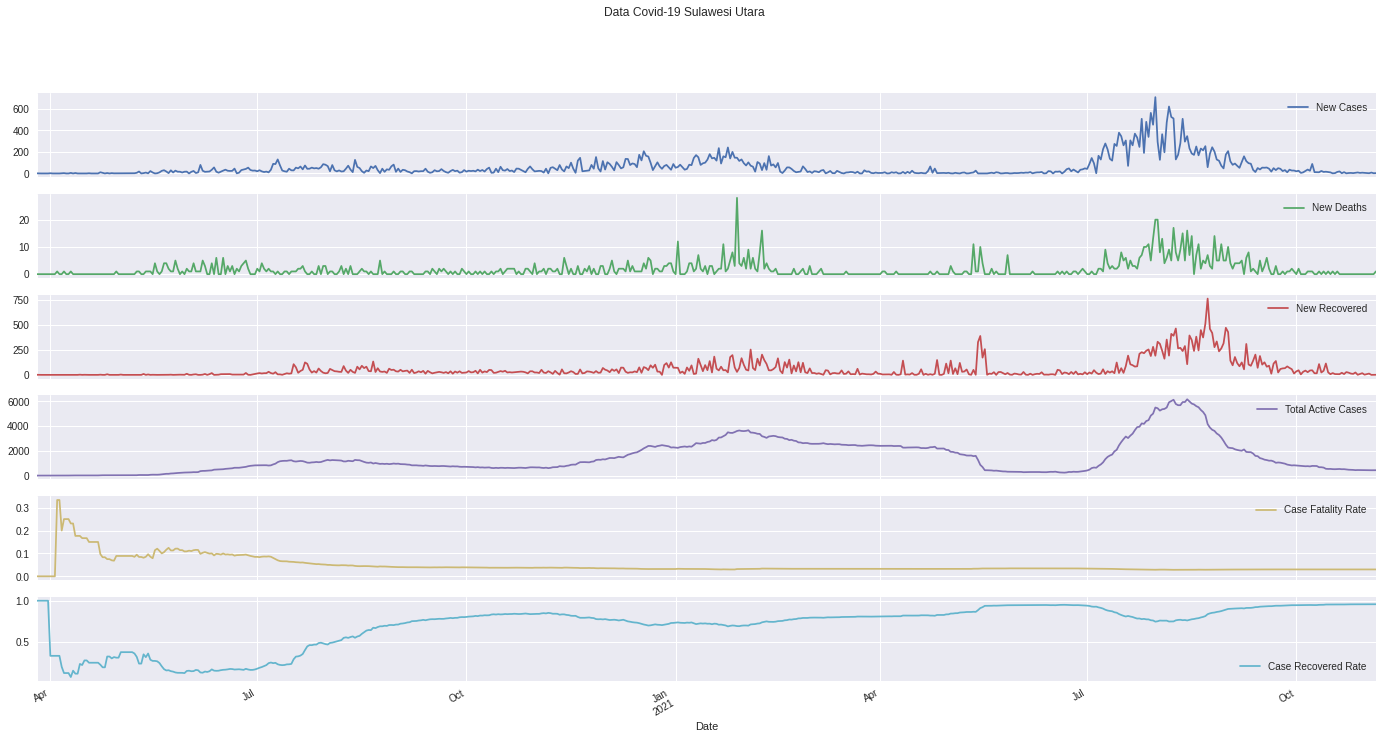

In [ ]:
#ambe khusus yang for sulawesi utara kong hapus tu kolom kolom yang nda perlu
dataset = df[df['Location'] == 'Sulawesi Utara'].copy()
dataset = dataset.drop(columns=[
  'Location', 
  'Province', 
  'Island',
  'New Active Cases',
  'Total Cases', 
  'Total Deaths', 
  'Total Recovered', 
  'Population', 
  'Population Density', 
  'Longitude', 
  'Latitude', 
  'New Cases per Million', 
  'Total Cases per Million',
  'New Deaths per Million',
  'Total Deaths per Million',
  'Total Deaths per 100rb',
])

plotScale = 6
mpl.rcParams['figure.figsize'] = (4*plotScale, 2*plotScale)

dataset.plot(subplots=True, x='Date', title='Data Covid-19 Sulawesi Utara')
dataset

In [ ]:
#kase sendiri tu feature 'Date'
dateTime = dataset.pop('Date')

#bagi tu dataset jadi train, test, deng validation
n = len(dataset)
trainDf = dataset[0:int(n * 0.7)]
valDf = dataset[int(n * 0.7):int(n * 0.9)]
testDf = dataset[int(n * 0.9):]

numFeatures = dataset.shape[1]

Karena nantinya data ini akan di masukkan ke model LSTM, data nya perlu dilakukan normalisasi guna menghindari nilai-nilai yang sangat tinggi atau sangat rendah yang akan mempengaruhi proses training.

In [ ]:
trainMean = trainDf.mean(numeric_only=True)
trainStd = trainDf.std(numeric_only=True)

trainDf = (trainDf - trainMean) / trainStd
valDf = (valDf - trainMean) / trainStd
testDf = (testDf - trainMean) / trainStd

In [ ]:
timestampS = dateTime.map(pd.Timestamp.timestamp)
timestampS

259      1.585181e+09
285      1.585267e+09
313      1.585354e+09
342      1.585440e+09
373      1.585526e+09
             ...     
20686    1.635725e+09
20719    1.635811e+09
20751    1.635898e+09
20782    1.635984e+09
20812    1.636070e+09
Name: Date, Length: 590, dtype: float64

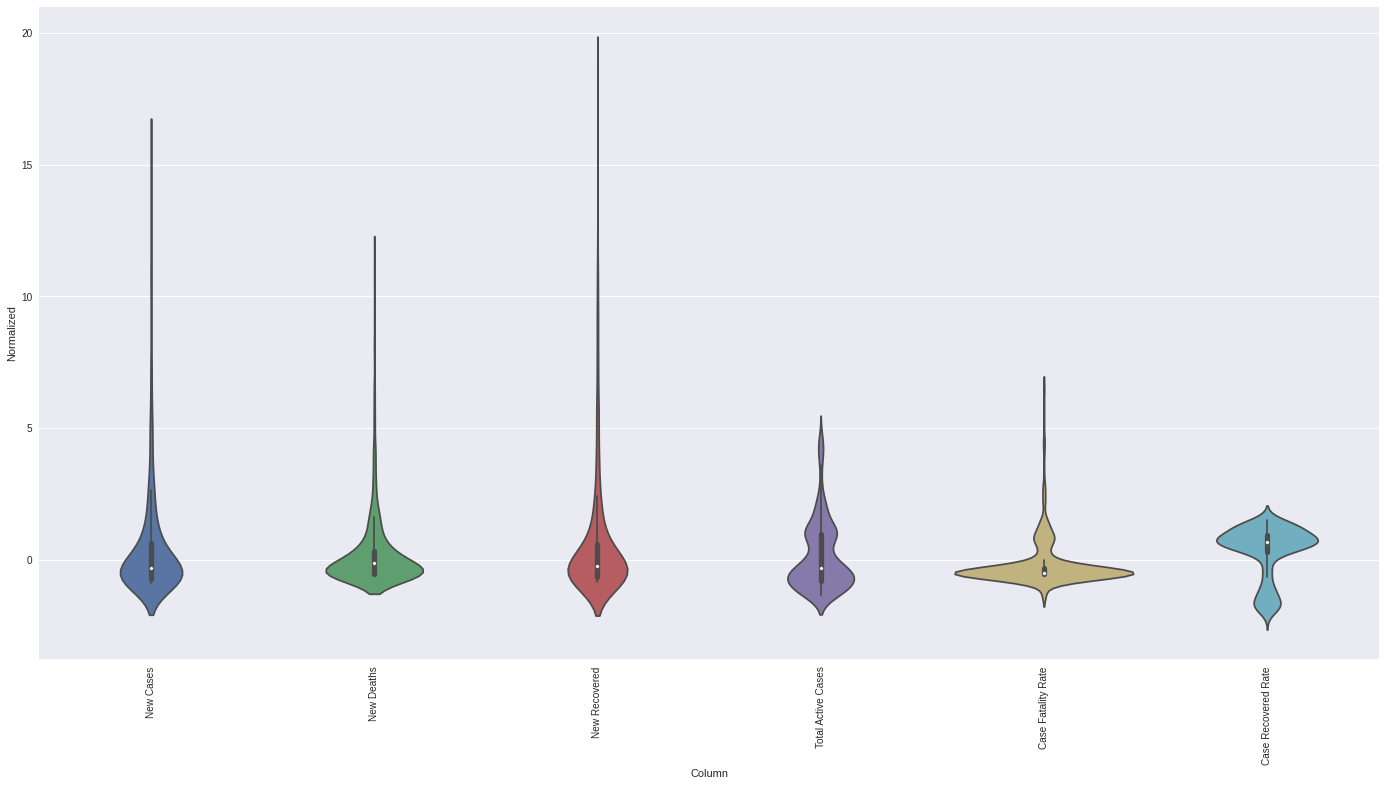

In [ ]:
datasetStd = (dataset - trainMean) / trainStd
datasetStd = datasetStd.melt(var_name='Column', value_name='Normalized')
plt.figure()
ax = sns.violinplot(x='Column', y='Normalized', data=datasetStd)
_ = ax.set_xticklabels(dataset.keys(), rotation=90)

Bagian coding ini diambil dari https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb#scrollTo=ZBBmdxZ2HgfJ

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=trainDf, val_df=valDf, test_df=testDf,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  ds = self.make_dataset(self.train_df)
  print("Train dataset count: ", len(list(ds)))
  return ds
  # return self.make_dataset(self.train_df)

@property
def val(self):
  ds = self.make_dataset(self.val_df)
  print("Validation dataset count: ", len(list(ds)))
  return ds
  # return self.make_dataset(self.val_df)

@property
def test(self):
  ds = self.make_dataset(self.test_df)
  print("Testing dataset count: ", len(list(ds)))
  return ds
  # self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
def predplot(window, model=None, plot_col='New Cases', max_subplots=3, figSize=(12, 8)):
  inputs, labels = window.example
  plt.figure(figsize=figSize)
  plot_col_index = window.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(window.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if window.label_columns:
      label_col_index = window.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(len(window.label_indices), labels[n, -1:, label_col_index],
                edgecolors='k', label='Ground Truth', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(len(window.label_indices), predictions[n, -1:, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

## Single-step Univariate Forecasting

Memperdiksi satu feature satu timestamp di masa depan dengan mempergunakan LSTM.

Sebagian besar coding disub-bab ini diambil dari : https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb#scrollTo=H4crpOcoMlSe

Dengan beberapa perubahan untuk mengadaptasikannya dengan data yang digunakan serta perubahan yang dilakukan oleh penulis untuk bereksperimen terhadap parameter-parameter yang disediakan.

Model yang digunakan dalam tahap ini ialah LSTM<br/>
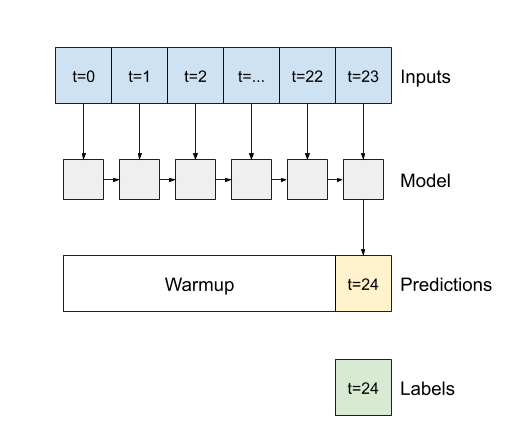
<br/>Tampak Model LSTM

Dalam tahap ini, feature yang akan diprediksi adalah ```New Cases```

Total window size: 59
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58]
Label column name(s): ['New Cases']
Train dataset count:  12
Train dataset count:  12
Validation dataset count:  2
Testing dataset count:  1


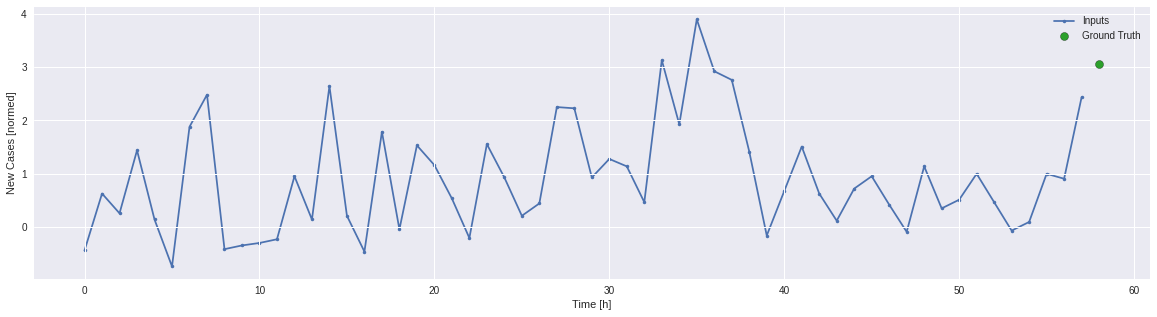

In [ ]:
uni_wide_window = WindowGenerator(
    input_width=58, label_width=58, shift=1,
    label_columns=['New Cases'])

print(uni_wide_window)

uni_wide_window.example
uni_wide_window.train
uni_wide_window.val
uni_wide_window.test

predplot(uni_wide_window, max_subplots=1, figSize=(20, 5))

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(256, return_sequences=True),
    Dropout(0.6),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
def compile_and_fit(model, window, patience=2, epochs=80, earlyStop=True):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  #perubahan sadiki supaya boleh mo ator dpe early stopping
  if earlyStop:
    history = model.fit(window.train, epochs=epochs,
                        validation_data=window.val,
                        callbacks=[early_stopping]
                        )
  else:
    history = model.fit(window.train, epochs=epochs,
                        validation_data=window.val,
                        )
  
  return history

In [ ]:
ssuv_history = compile_and_fit(lstm_model, uni_wide_window, epochs=500, patience=15)

Train dataset count:  12
Validation dataset count:  2
Epoch 1/500
12/12 [==============================] - 8s 265ms/step - loss: 0.5957 - mean_absolute_error: 0.5425 - val_loss: 8.1669 - val_mean_absolute_error: 1.8612
Epoch 2/500
12/12 [==============================] - 3s 212ms/step - loss: 0.4739 - mean_absolute_error: 0.4829 - val_loss: 9.0441 - val_mean_absolute_error: 1.9774
Epoch 3/500
12/12 [==============================] - 3s 219ms/step - loss: 0.4519 - mean_absolute_error: 0.4709 - val_loss: 9.0065 - val_mean_absolute_error: 1.9670
Epoch 4/500
12/12 [==============================] - 3s 211ms/step - loss: 0.4396 - mean_absolute_error: 0.4641 - val_loss: 9.4348 - val_mean_absolute_error: 2.0234
Epoch 5/500
12/12 [==============================] - 3s 211ms/step - loss: 0.4289 - mean_absolute_error: 0.4589 - val_loss: 9.3663 - val_mean_absolute_error: 2.0226
Epoch 6/500
12/12 [==============================] - 3s 212ms/step - loss: 0.4212 - mean_absolute_error: 0.4548 - val_los

Validation dataset count:  2
2/2 [==============================] - 0s 52ms/step - loss: 20.2013 - mean_absolute_error: 3.0528
Testing dataset count:  1


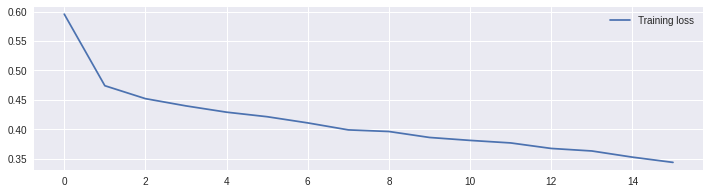

In [ ]:
val_performance = {}
performance = {}
# print(wide_window.val)
val_performance['LSTM'] = lstm_model.evaluate(uni_wide_window.val)
performance['LSTM'] = lstm_model.evaluate(uni_wide_window.test, verbose=0)
plt.rcParams["figure.figsize"] = (12,3)
plt.plot(ssuv_history.history['loss'], label='Training loss')
plt.legend()

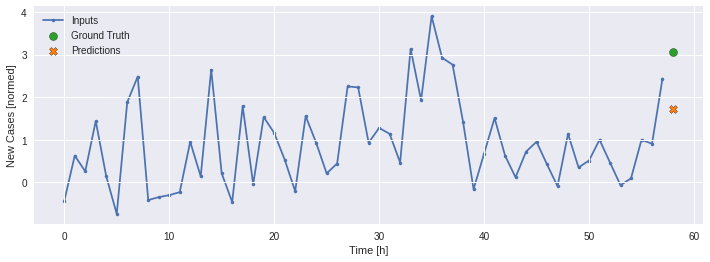

In [ ]:
predplot(uni_wide_window, lstm_model, max_subplots=1, figSize=(12,4))

## Single-step Multi-variate/Multi-output Forecasting

Memprediksi lebih dari satu feature satu timestamp di masa depan dengan mempergunakan Residual LSTM

Sebagian besar coding disub-bab ini diambil dari : https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb#scrollTo=UwhY2f_Nn0_K

Dengan beberapa perubahan untuk mengadaptasikannya dengan data yang digunakan serta perubahan yang dilakukan oleh penulis untuk bereksperimen terhadap parameter-parameter yang disediakan.

Model yang digunakan dalam tahap ini adalah LSTM dengan Residual Connection<br/>

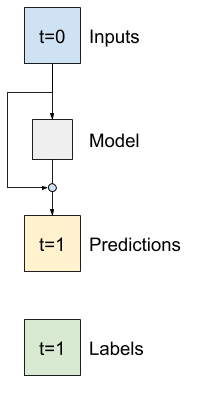

<br/>Tampak Residual Connection

Pada tahap ini, feature-feature yang akan diprediksi adalah ```New Cases```, ```New Deaths```, ```Case Fatality Rate```, dan ```Case Recovered Rate```


In [ ]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

multi_wide_window = WindowGenerator(
    input_width=58, label_width=58, shift=1)

for example_inputs, example_labels in multi_wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Train dataset count:  12
Inputs shape (batch, time, features): (32, 58, 6)
Labels shape (batch, time, features): (32, 58, 6)


In [ ]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [ ]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(256, return_sequences=True),
    Dropout(0.7),
    tf.keras.layers.LSTM(128, return_sequences=True),
    Dropout(0.7),
    tf.keras.layers.Dense(
        numFeatures,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

ssmvmo_history = compile_and_fit(residual_lstm, multi_wide_window, epochs=999, patience=2)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(multi_wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(multi_wide_window.test, verbose=0)


Validation dataset count:  2
2/2 [==============================] - 0s 89ms/step - loss: 2.4310 - mean_absolute_error: 0.7130
Testing dataset count:  1
CPU times: user 1min 12s, sys: 3.8 s, total: 1min 15s
Wall time: 53.3 s


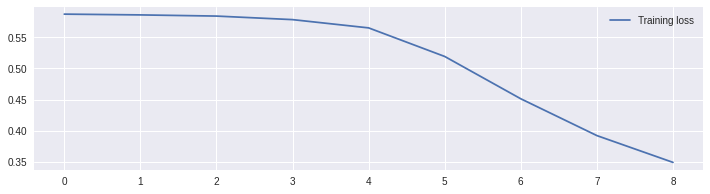

In [ ]:
plt.rcParams["figure.figsize"] = (12,3)
plt.plot(ssmvmo_history.history['loss'], label='Training loss')
plt.legend()

Train dataset count:  12


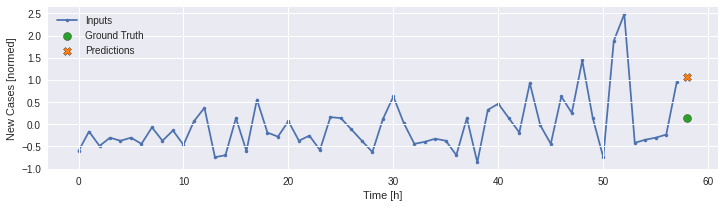

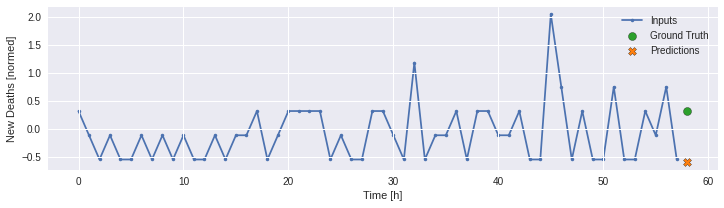

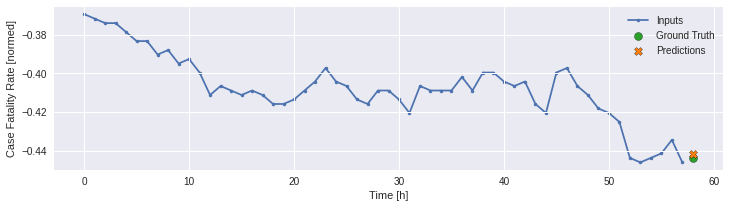

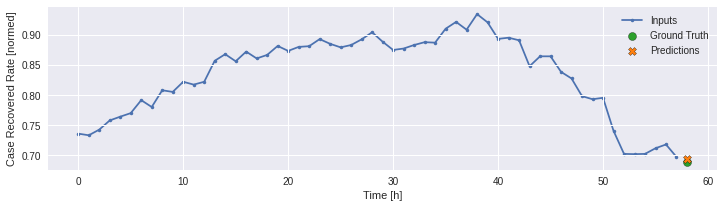

In [ ]:
figSize = (12, 3)

predplot(multi_wide_window, model=residual_lstm, plot_col='New Cases', max_subplots=1, figSize=figSize)
predplot(multi_wide_window, model=residual_lstm, plot_col='New Deaths', max_subplots=1, figSize=figSize)
predplot(multi_wide_window, model=residual_lstm, plot_col='Case Fatality Rate', max_subplots=1, figSize=figSize)
predplot(multi_wide_window, model=residual_lstm, plot_col='Case Recovered Rate', max_subplots=1, figSize=figSize)

# Multi-step Multi-variate Multi-output Forecasting

Melakukan prediksi beberapa features untuk beberapa hari kedepan

In [ ]:
def multipredplot(window, model=None, plot_col='New Cases', max_subplots=3, figSize=(12, 8)):
  inputs, labels = window.example
  plt.figure(figsize=figSize)
  plot_col_index = window.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(window.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if window.label_columns:
      label_col_index = window.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(window.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Ground Truth', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(window.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

Train dataset count:  10


Total window size: 116
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57]
Label indices: [ 58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115]
Label column name(s): None

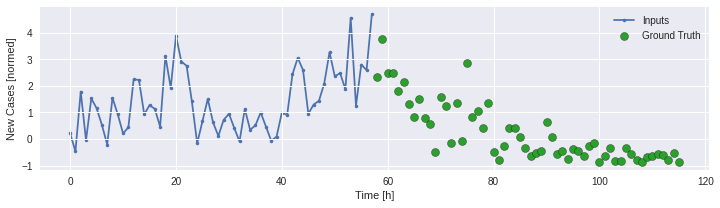

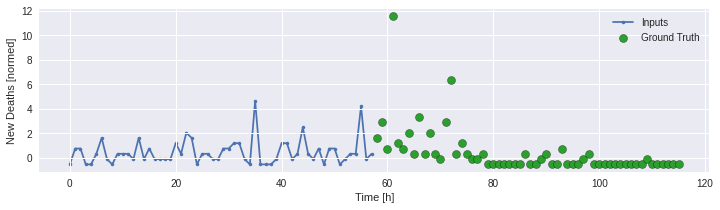

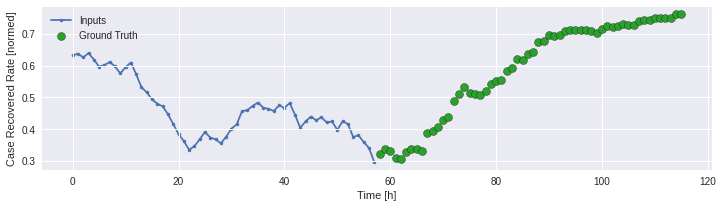

In [ ]:
OUT_STEPS = 58
multi_window = WindowGenerator(input_width=58,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

figSize = (12, 3)

multipredplot(multi_window, plot_col='New Cases', max_subplots=1, figSize=figSize)
multipredplot(multi_window, plot_col='New Deaths', max_subplots=1, figSize=figSize)
multipredplot(multi_window, plot_col='Case Recovered Rate', max_subplots=1, figSize=figSize)
multi_window

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(numFeatures)

In [ ]:
feedback_model = FeedBack(units=256, out_steps=OUT_STEPS)

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 6])

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 58, 6)


In [ ]:
msmvmo_history = compile_and_fit(feedback_model, multi_window, epochs=999, patience=2)
multi_val_performance = {}
multi_performance = {}
multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)


Train dataset count:  10
Validation dataset count:  1
Epoch 1/999
10/10 [==============================] - 17s 575ms/step - loss: 0.5845 - mean_absolute_error: 0.4909 - val_loss: 13.0224 - val_mean_absolute_error: 2.2714
Epoch 2/999
10/10 [==============================] - 4s 381ms/step - loss: 0.4797 - mean_absolute_error: 0.4214 - val_loss: 11.2271 - val_mean_absolute_error: 2.0454
Epoch 3/999
10/10 [==============================] - 4s 377ms/step - loss: 0.4075 - mean_absolute_error: 0.3802 - val_loss: 12.1935 - val_mean_absolute_error: 2.1284
Epoch 4/999
10/10 [==============================] - 4s 376ms/step - loss: 0.3712 - mean_absolute_error: 0.3343 - val_loss: 13.6047 - val_mean_absolute_error: 2.3005
Validation dataset count:  1
1/1 [==============================] - 0s 101ms/step - loss: 13.6047 - mean_absolute_error: 2.3005
Testing dataset count:  0


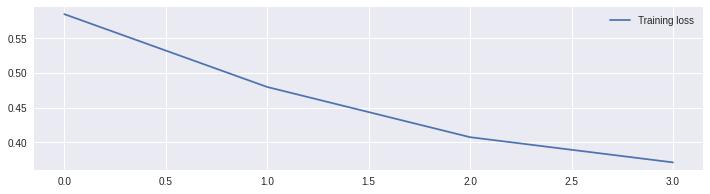

In [ ]:
plt.rcParams["figure.figsize"] = (12,3)
plt.plot(msmvmo_history.history['loss'], label='Training loss')
plt.legend()

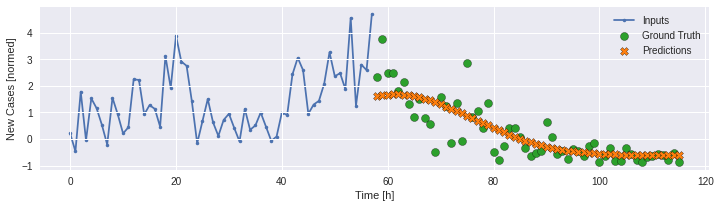

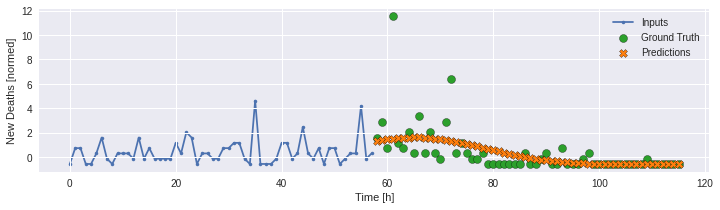

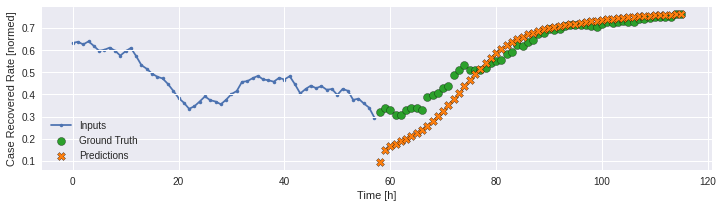

In [ ]:
multipredplot(multi_window, feedback_model, plot_col='New Cases', max_subplots=1, figSize=figSize)
multipredplot(multi_window, feedback_model, plot_col='New Deaths', max_subplots=1, figSize=figSize)
multipredplot(multi_window, feedback_model, plot_col='Case Recovered Rate', max_subplots=1, figSize=figSize)

# Seasonal Decomposition

Seasonal decomposition memisahkan karakteristik `Trend` dan `Seasonal` dari sebuah data time series guna melihat karakteristik tersebut tanpa noise dari data itu.

Dalam hal ini, analisa Seasonal Decomposition dilakukan terhadap feature `New Cases` dan `New Deaths`

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

Parameter frekuensi yang digunakan dalam dekomposisi ini adalah `31` yang merepresentasikan siklus satu bulan.

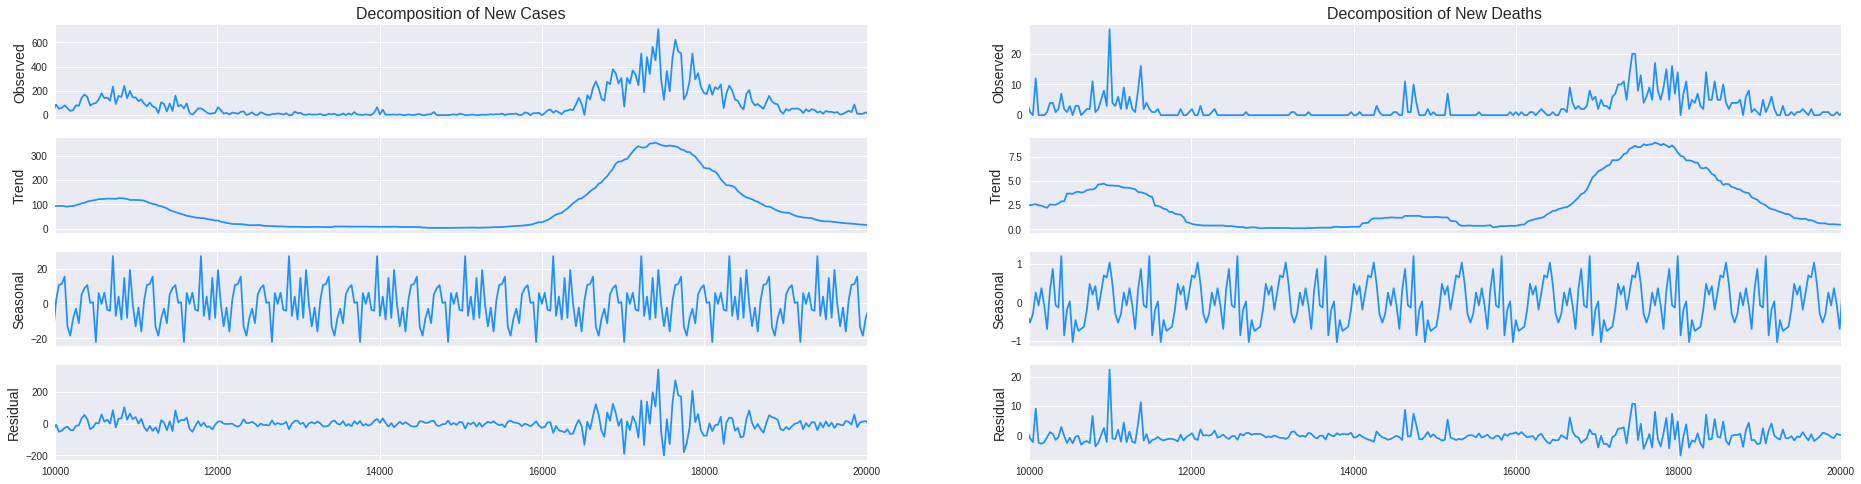

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(32,8))
res = seasonal_decompose(dataset['New Cases'], model='additive', freq=31)

ax[0,0].set_title('Decomposition of New Cases', fontsize=16)
res.observed.plot(ax=ax[0,0], legend=False, color='dodgerblue')
ax[0,0].set_ylabel('Observed', fontsize=14)

res.trend.plot(ax=ax[1,0], legend=False, color='dodgerblue')
ax[1,0].set_ylabel('Trend', fontsize=14)

res.seasonal.plot(ax=ax[2,0], legend=False, color='dodgerblue')
ax[2,0].set_ylabel('Seasonal', fontsize=14)

res.resid.plot(ax=ax[3,0], legend=False, color='dodgerblue')
ax[3,0].set_ylabel('Residual', fontsize=14)

ax[0,1].set_title('Decomposition of New Deaths', fontsize=16)
res = seasonal_decompose(dataset['New Deaths'], model='additive', freq=31)

res.observed.plot(ax=ax[0, 1], legend=False, color='dodgerblue')
ax[0, 1].set_ylabel('Observed', fontsize=14)

res.trend.plot(ax=ax[1, 1], legend=False, color='dodgerblue')
ax[1, 1].set_ylabel('Trend', fontsize=14)

res.seasonal.plot(ax=ax[2, 1], legend=False, color='dodgerblue')
ax[2, 1].set_ylabel('Seasonal', fontsize=14)

res.resid.plot(ax=ax[3, 1], legend=False, color='dodgerblue')
ax[3, 1].set_ylabel('Residual', fontsize=14)

ax[0, 0].set_xlim([10000, 20000])

plt.show()

# Model Klasifikasi Sederhana

Kali ini kita akan membuat model sederhana yang dapat menklasifikasi apakah sebuah urutan angka dari data New Active Cases itu menunjukkan kenaikan atau menunjukkan penurunan.


## Feature Engineering

Untuk dapat melakukan klasifikasi tersebut, kita perlu membuat feature baru yang menunjukkan apakah sebuah urutan angka menunjukkan kenaikan maupun penurunan.

Dalam hal ini, kita akan menggunakkan `numpy.polyfit()` untuk membantu kita membuat feature tersebut.

`numpy.polyfit()` akan mencoba untuk menarik sebuah garis trend berdasarkan dari urutan data angka yang diberikan ke fungsi tersebut.

Dalam hal ini, output yang dihasilkan adalah nilai untuk variabel `a` dan `b` dalam fungsi `y = ax + b`

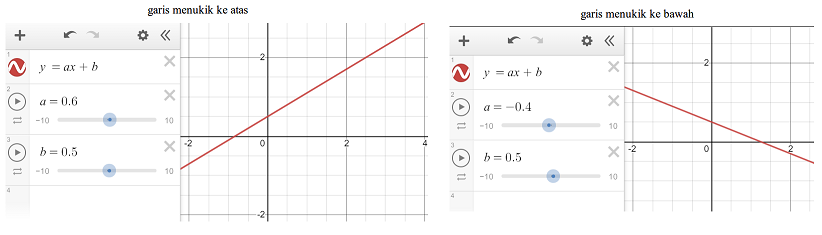

dengan mempergunakan `numpy.polyfit()` terhadap deretan angka New Active Cases, kita akan bisa membuat feature yang menunjukkan apakah deretan angka tersebut menunjukkan kenaikan, atau penurunan. Nantinya ini akan dipakai sebagai label untuk model klasifikasi kita.

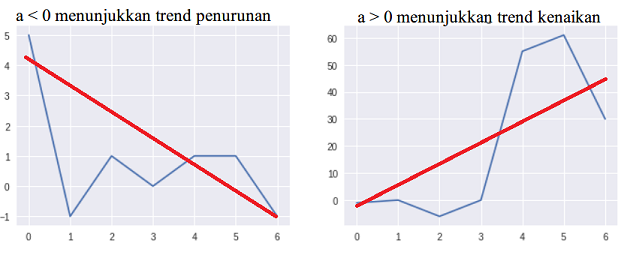

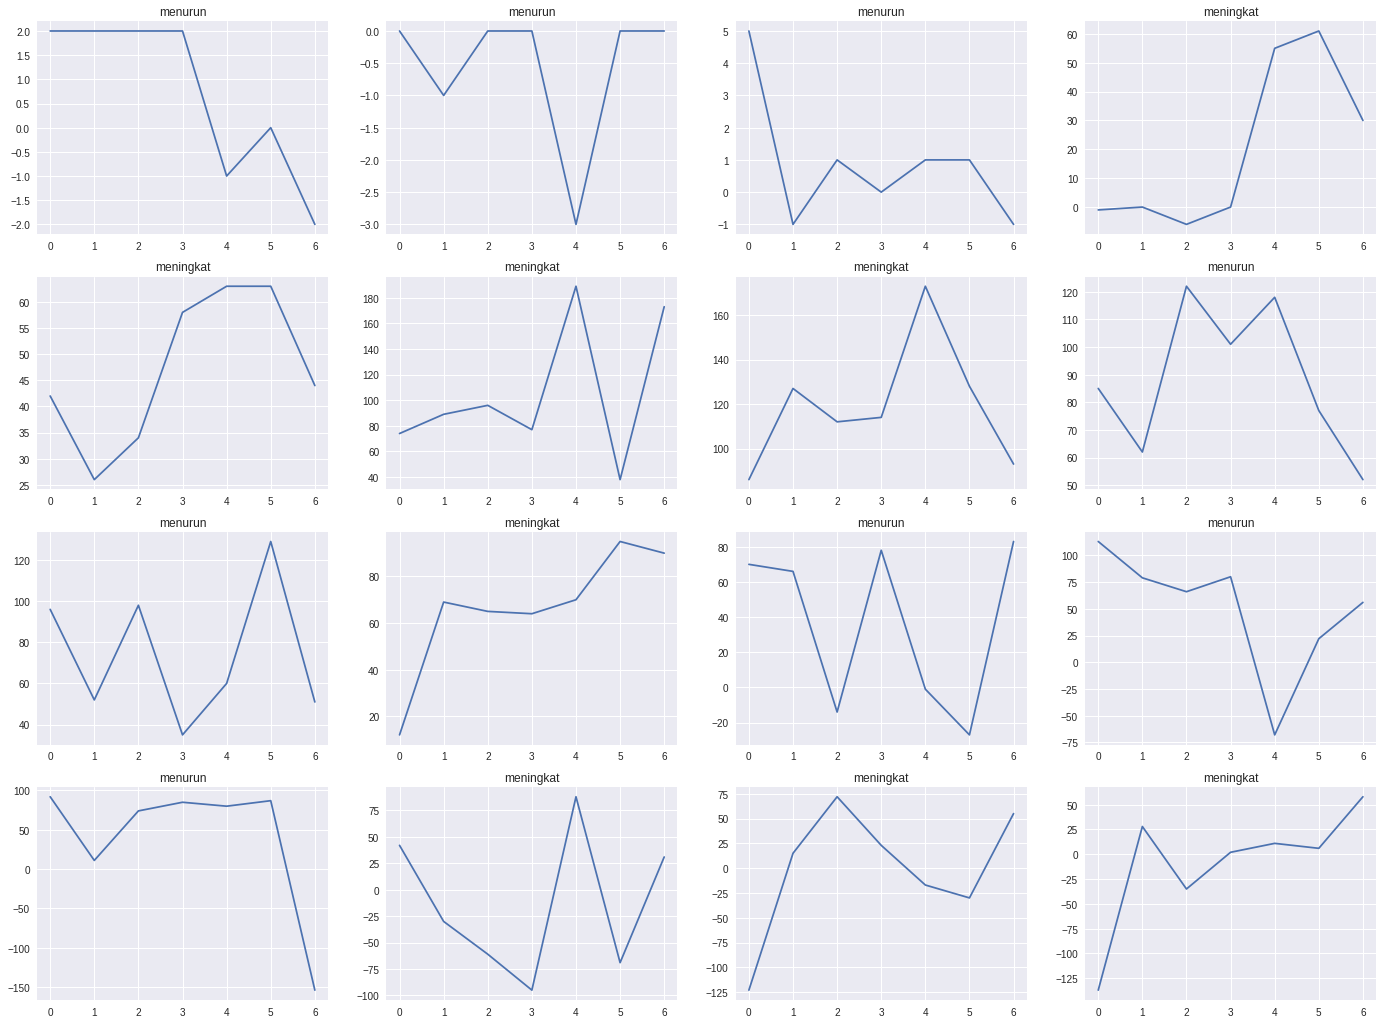

In [ ]:
newActiveCasesVal = []

for location in df['Location'].unique():
  provinceDf = df[df['Location'] == location][['New Active Cases']]

  # ambe angka mentah dari dataframe provinceDf dari kolom 'New Active Cases'
  newActiveCases = [x[1]['New Active Cases'] for x in list(provinceDf.iterrows())]

  # depe data new active cases ini banyak noise, torang se ilang tu noise kong se tinggal depe trend
  #
  # tu [30:-15] diterakhir itu mo se ilang missing/null value gegara torang da pake seasonal_decompose
  newActiveCasesTrend = list(seasonal_decompose(newActiveCases, model='additive', freq=31).trend)[30:-15]

  for dataColumn in range(0, len(newActiveCasesTrend), 7):
    slicedValues = newActiveCases[dataColumn:dataColumn + 7]
    label = ''

    # cari tau ini kumpulan data new active cases meningkat ato menurut pake numpy.polyfit.
    # nanti ini polyfit mo kase tau nilai variabel 'a' dengan 'b' dari y = ax + b (garis linear)
    # sumber : https://stackoverflow.com/questions/10048571/python-finding-a-trend-in-a-set-of-numbers
    sumbuX = np.arange(0, len(slicedValues))
    sumbuY = np.array(slicedValues)
    z = np.polyfit(sumbuX, sumbuY, 1)

    # cek kalo variabel 'a' itu nol ato negatif,
    # kalo betul, berarti tu garis itu ada ba bengko ka bawah (menurun)
    if z[0] <= 0:
      label = 'menurun'
    # kalo variabel 'a' positif, berarti tu garis ada ba bengko ka atas (meningkat)
    else:
      label = 'meningkat'
    
    newActiveCasesVal.append([slicedValues, label])

fig, axes = plt.subplots(4, 4, figsize=(24,18))

for row in range(4):
  for i, dataGroup in enumerate(newActiveCasesVal[row*4:row*4 + 4]):
    axes[row, i].plot(dataGroup[0])
    axes[row, i].set_title(dataGroup[1])

In [ ]:
print("Jumlah data = ", len(newActiveCasesVal))

Jumlah data =  2681


Sekarang kita akan memisahkan datanya menjadi Training dataset dan Validation dataset, dengan rasio 80/20.

Khusus untuk label `'meningkat'` dan `'menurun'`, kita akan merubahnya menjadi angka 0 untuk `'menurun'` dan 1 untuk `'meningkat'`

In [ ]:
xTrain = []
yTrain = []
xVal = []
yVal = []

for row in newActiveCasesVal[:int(len(newActiveCasesVal) * 0.8)]:
  xTrain.append(row[0])
  yTrain.append(0 if row[1] == 'menurun' else 1)

for row in newActiveCasesVal[int(len(newActiveCasesVal) * 0.8):]:
  xVal.append(row[0])
  yVal.append(0 if row[1] == 'menurun' else 1)

print("Training dataset: ", len(xTrain) / len(newActiveCasesVal), "\nValdation dataset: ", len(xVal) / len(newActiveCasesVal))

Training dataset:  0.7997016038791496 
Valdation dataset:  0.20029839612085043


## Model Training
bagian code ini diambil dari: [SVM Classification - SciKit-Learn Python](https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python)

Dalam hal ini kita akan menggunakkan SVM dengan kernel RBF karena dimensi features kita tinggi yaitu `7` dimensi. Berdasarkan penjelasan di link diatas, kernel RBF baik dalam menangani input data dengan dimensi yang tinggi

> **Radial Basis Function Kernel** The Radial basis function kernel is a popular kernel function commonly used in support vector machine classification. RBF can map an input space in infinite dimensional space.



In [ ]:
from sklearn import svm

clf = svm.SVC(kernel='rbf')

clf.fit(xTrain, yTrain)
yPred = clf.predict(xVal)

## Performance Evaluation and Classification Visualization
Sekarang kita akan menampilkan akurasi dan confusion matrix dari model kita.

Khusus untuk confusion matrix, disini kita dapat melihat dibagian mana model kita kebingungan dalam melakukan klasifikasi

Accuracy: 0.8789571694599627


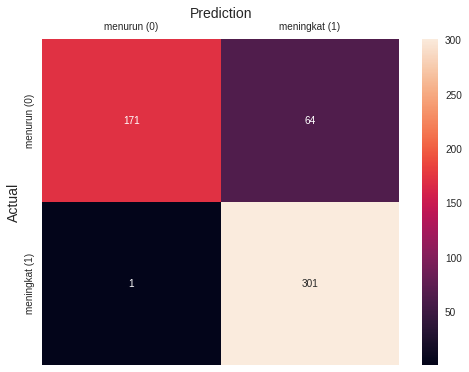

In [ ]:
from sklearn import metrics
confusion_matrix(yVal, yPred)

fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(confusion_matrix(y_true = yVal, y_pred = yPred), fmt = 'g', annot = True)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('Prediction', fontsize = 14)
ax.set_xticklabels(['menurun (0)', 'meningkat (1)'])
ax.set_ylabel('Actual', fontsize = 14)
ax.set_yticklabels(['menurun (0)', 'meningkat (1)'])
plt.show()

Menampilkan Akurasi, RMSE, precision, recall, f1-score, dan support

In [ ]:
print("Accuracy:",metrics.accuracy_score(yVal, yPred))
print("rmse/root mean squared error :", metrics.mean_squared_error(yPred, yVal))

print(metrics.classification_report(yPred, yVal))

Accuracy: 0.8789571694599627
rmse/root mean squared error : 0.12104283054003724
              precision    recall  f1-score   support

           0       0.73      0.99      0.84       172
           1       1.00      0.82      0.90       365

    accuracy                           0.88       537
   macro avg       0.86      0.91      0.87       537
weighted avg       0.91      0.88      0.88       537



Nah akhirnya, kita akan melihat bagaimana model kita memprediksi data deretan New Active Cases yang kita berikan dengan visualisasi graf.

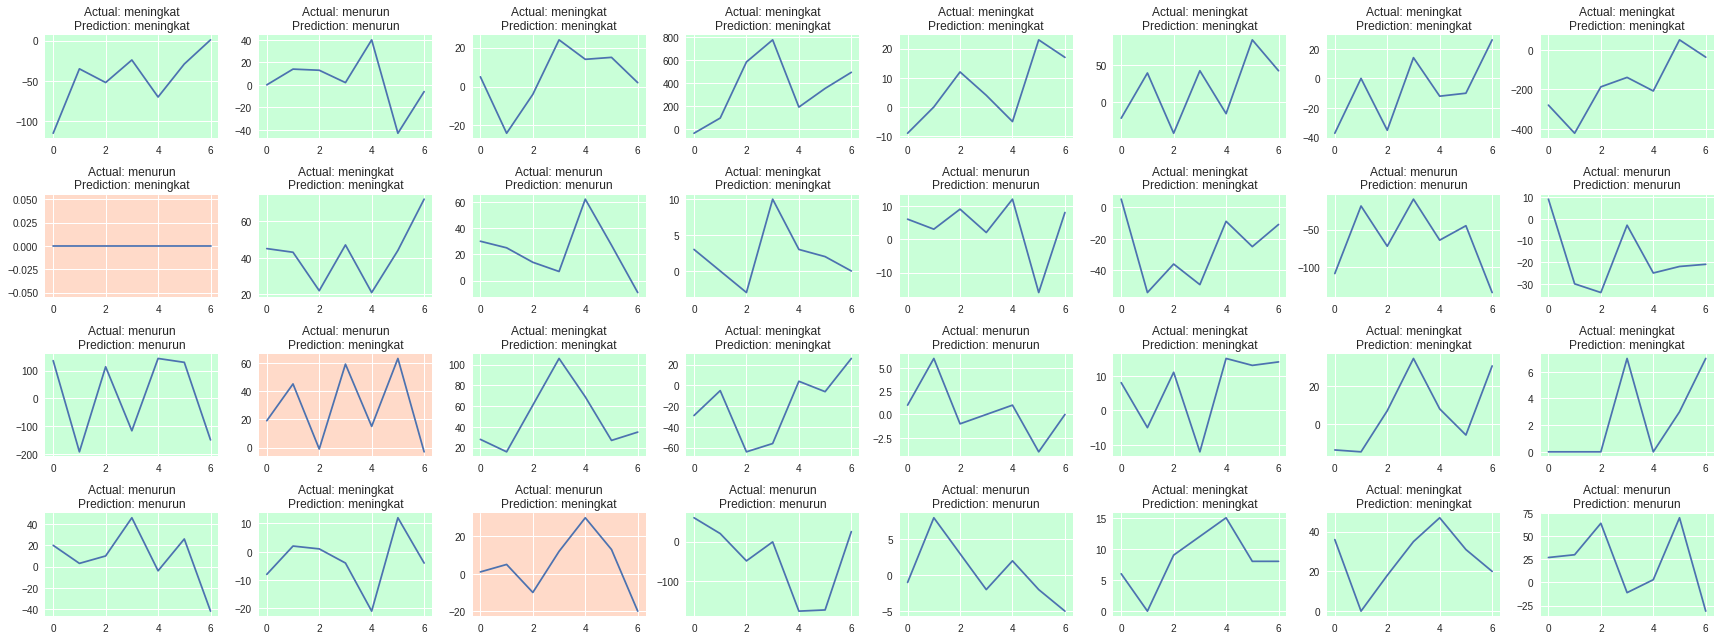

In [ ]:
import random
fig, axes = plt.subplots(4, 8, figsize=(24,9))

# torang gabung tu xVal, yVal, dengan yPred jadi satu list
predictions = list(zip(xVal, yVal, yPred))
random.shuffle(predictions)

# torang mo se tampilkan 4 baris ke bawah
for row in range(4):
  # torang mo se tampilkan 8 baris ke kanan
  for i, dataGroup in enumerate(predictions[row*8:row*8 + 8]):
    # plot tu data dari xVal
    axes[row, i].plot(dataGroup[0])

    # ator dpe title berdasarkan tu yVal dengan yPred
    axes[row, i].set_title(f"Actual: {'menurun' if dataGroup[1] == 0 else 'meningkat'}\nPrediction: {'menurun' if dataGroup[2] == 0 else 'meningkat'}")

    # supaya nda susah mo lia, torang kase warna hijau dpe background kalo misal depe actual class dengan predicted class itu sama
    # kong kase warna merah kalo misal baku beda
    if dataGroup[1] == dataGroup[2]:
      axes[row, i].set_facecolor('#c9ffd8')
    else:
      axes[row, i].set_facecolor('#ffdac9')

# ini mo auto fix depe margin dari tu tiap graf, gegara tadi qt
# ada tes sebelum pake ini fig.tight_layout(), ta baku cako
fig.tight_layout()

# Sekian dan Terima Kasih

Oleh : Timothy Merfry Tiwow (S21810014/105021810004) <br/>
Untuk kelas : Data Science Programming A